In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta 
from sklearn.preprocessing import StandardScaler

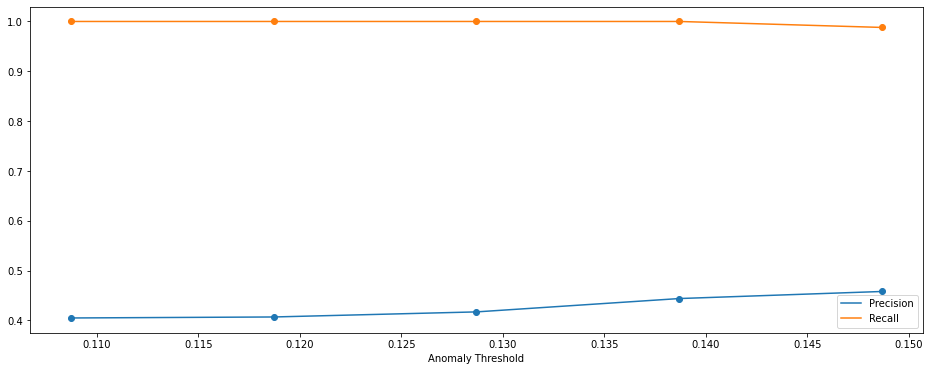

In [3]:
thresholdValues = [0.1087, 0.1187, 0.1287, 0.1387, 0.1487]
precisionValues = [0.4049, 0.4069, 0.4171, 0.4439, 0.4581]
recallValues = [1, 1, 1, 1, 0.988]

plt.figure(figsize=(16, 6))
plt.plot(thresholdValues, precisionValues)
plt.scatter(thresholdValues, precisionValues)
plt.plot(thresholdValues, recallValues)
plt.scatter(thresholdValues, recallValues)
plt.xlabel('Anomaly Threshold')
plt.legend(['Precision', 'Recall'], loc='lower right')
plt.show()

### Load Dataset

Make sure that training and validation set end at episode.

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [4]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [5]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [6]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul

In [7]:
#drop na columns 
all_df = all_df.dropna()

In [8]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [9]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [10]:
def getSensorReadingsOnlyNoEpisode(lst):
    result = []
    time = []
    for episode in lst:
        for row in episode:
            row_formatted = row[1:5]
            result.append(row_formatted)
            time.append(row[0])
    return (result, time)

In [11]:
#set random seed 
import tensorflow as tf
tf.random.set_seed(42)

In [12]:
train_arr, trainTime = getSensorReadingsOnlyNoEpisode(train_data)
val_arr, valTime = getSensorReadingsOnlyNoEpisode(val_data)
test_arr, testTime = getSensorReadingsOnlyNoEpisode(test_data)

In [13]:
train_arr

[[0.379151092, 0.5563851870000001, 0.24307950600000003, 0.229504293],
 [0.415506993, 0.698561103, 0.242410288, 0.273824561],
 [0.33934205, 0.637644818, 0.230266358, 0.191588098],
 [0.343817356, 0.627731997, 0.233904513, 0.264566349],
 [0.310361557, 0.6073681129999999, 0.19429564300000002, 0.240200195],
 [0.33632763600000004, 0.531479142, 0.215693485, 0.215780325],
 [0.397831149, 0.57521239, 0.19058554600000002, 0.230599092],
 [0.385974096, 0.630933953, 0.208516333, 0.24769339699999998],
 [0.376943194, 0.39604728299999997, 0.215659658, 0.256992779],
 [0.56498231, 0.648197926, 0.516587151, 0.256162471],
 [0.35186714700000005, 0.647795783, 0.257161825, 0.276671218],
 [0.353867353, 0.615858294, 0.19700913399999997, 0.26938823100000003],
 [0.38416982299999997, 0.622861995, 0.199791766, 0.305659257],
 [0.35315408200000004, 0.5978954089999999, 0.2172971, 0.265631153],
 [0.382126061, 0.655505276, 0.231748822, 0.258702261],
 [0.374770865, 0.6761454509999999, 0.243662648, 0.259956326],
 [0.40600

In [14]:
def getStateValues(lst):
    stateList = []
    for episode in lst:
        for row in episode:
            stateValue = int(row[6])
            stateList.append(stateValue)
    return stateList

In [15]:
train_state = getStateValues(train_data)
val_state = getStateValues(val_data)
test_state = getStateValues(test_data)

In [16]:
total_num = len(train_state)
failure_states = [i for i in train_state if i > 3]
failure_num = len(failure_states)
outlier_ratio = failure_num/total_num
print("Estimated percentage of outliers %f" % outlier_ratio)

Estimated percentage of outliers 0.083361


In [17]:
def viewOutliers(clf):
    #training set
    y_train_scores = clf.decision_scores_
    plt.hist(y_train_scores, bins='auto') 
    plt.title("Histogram for training set anomaly scores")
    plt.show()
    
    #validation set
    y_val_scores = clf.decision_function(val_arr)  # outlier scores
    y_val_scores = pd.Series(y_val_scores)
    plt.hist(y_val_scores, bins='auto') 
    plt.title("Histogram for validation set anomaly scores")
    plt.show()

### Train CBLOF

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


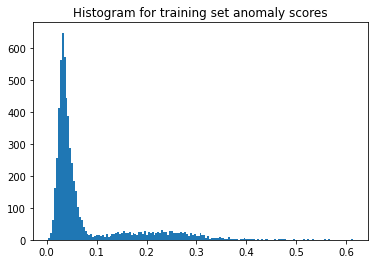

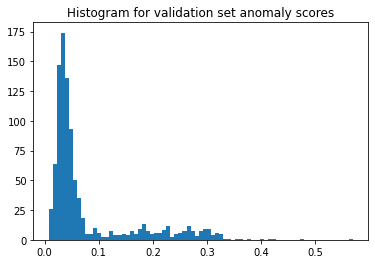

In [20]:
from pyod.models.cblof import CBLOF
clf1 = CBLOF(n_clusters=20, alpha=0.75, random_state=42, contamination=outlier_ratio)
clf1.fit(train_arr)
viewOutliers(clf1)

In [21]:
import statistics
#find mean 
train_score = clf1.decision_function(train_arr)
trainMean = statistics.mean(train_score)
trainMean

0.0776835327628265

In [22]:
#find standard deviation
trainStdev = statistics.stdev(train_score)
trainStdev

0.0861870258800918

In [23]:
#1 standard deviation away 
trainMean + trainStdev

0.1638705586429183

In [24]:
#2 standard deviation away 
trainMean + trainStdev*2

0.2500575845230101

In [18]:
def findFailureIndex(data):
    orderlist = []
    for order in range(len(data)):
        if data[order] > 3:
            orderlist.append(order)
    return orderlist

In [19]:
def findDegradeIndex(data): #includes state 3
    orderlist = []
    for order in range(len(data)):
        if data[order] > 2:
            orderlist.append(order)
    return orderlist

In [20]:
def getValuebyIndex(data, indexList):
    output = []
    for order in indexList:
        output.append(data[order])
    return output

In [21]:
def getNormalIndex(data):
    orderlist = []
    for order in range(len(data)):
        if data[order] < 4:
            orderlist.append(order)
    return orderlist

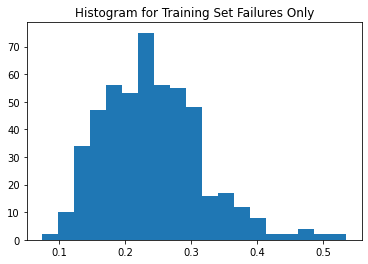

In [28]:
#find anomaly threshold by failure anomaly scores 
train_failureIndex = findFailureIndex(train_state)
train_failureScores = getValuebyIndex(train_score, train_failureIndex)
plt.hist(train_failureScores, bins='auto')
plt.title("Histogram for Training Set Failures Only")
plt.show()

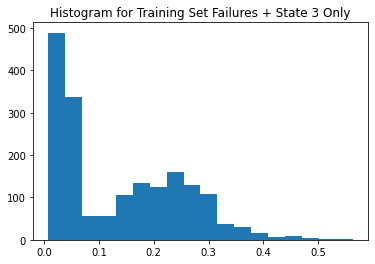

In [29]:
#find anomaly threshold by significant degradation anomaly scores 
train_degradationIndex = findDegradeIndex(train_state)
train_degradationScores = getValuebyIndex(train_score, train_degradationIndex)
plt.hist(train_degradationScores, bins='auto')
plt.title("Histogram for Training Set Failures + State 3 Only")
plt.show()

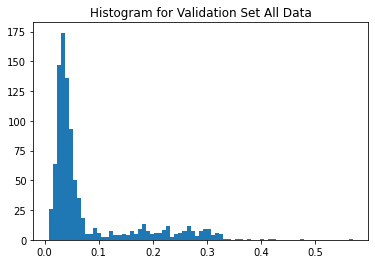

In [30]:
val_score = clf1.decision_function(val_arr)
plt.hist(val_score, bins='auto')
plt.title("Histogram for Validation Set All Data")
plt.show()

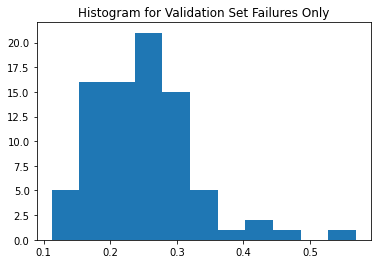

In [31]:
#find anomaly threshold by state
#failure data 
val_failureIndex = findFailureIndex(val_state)
val_failureScores = getValuebyIndex(val_score, val_failureIndex)
plt.hist(val_failureScores, bins='auto')
plt.title("Histogram for Validation Set Failures Only")
plt.show()

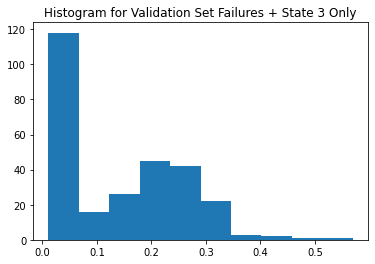

In [32]:
#find anomaly threshold by state
#failure data + state 3
val_degradationIndex = findDegradeIndex(val_state)
val_degradationScores = getValuebyIndex(val_score, val_degradationIndex)
plt.hist(val_degradationScores, bins='auto')
plt.title("Histogram for Validation Set Failures + State 3 Only")
plt.show()

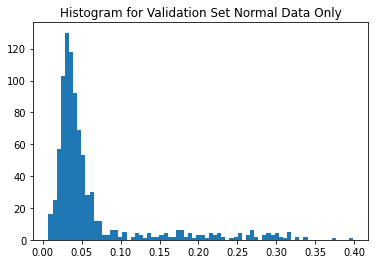

In [35]:
#normal data 
val_normalIndex = getNormalIndex(val_state)
val_normalScores = getValuebyIndex(val_score, val_normalIndex)
plt.hist(val_normalScores, bins='auto')
plt.title("Histogram for Validation Set Normal Data Only")
plt.show()

In [36]:
#find mean (validation)
valMean = statistics.mean(val_normalScores)
valMean

0.06265500330281822

In [37]:
#find standard deviation (validation)
valStdev = statistics.stdev(val_normalScores)
valStdev

0.06753635610430969

In [38]:
#1 standard deviation away 
valMean + valStdev

0.1301913594071279

In [39]:
#2 standard deviation away 
valMean + valStdev*2

0.19772771551143759

In [4]:
def processAnomalyWithoutState3(anomalyScores, data, threshold, dataType):
    
    #initialise variables
    anomalousStateListTrain = []
    anomalousStatePreListTrain = []
    anomalousStatePostListTrain = []
    anomalousCountTrain = 0
    
    anomalousStateListVal = []
    anomalousStatePreListVal = []
    anomalousStatePostListVal = []
    anomalousCountVal = 0
    
    anomalousStateListTest = []
    anomalousStatePreListTest = []
    anomalousStatePostListTest = []
    anomalousCountTest = 0
    
    for order in range(0, len(anomalyScores)):
        score = anomalyScores[order]
        if score > threshold: #is anomaly
            reading = data[order].tolist()
            
            #process anomaly and count 
            anomalousIndex = 0
            for n in range(0, len(allValuesList)):
                row = allValuesList[n]
                if row[1:5] == reading: #is anomaly
                    anomalousIndex = n
                    if (dataType == 'Train'):
                        anomalousStateListTrain.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTrain.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTrain.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTrain =  anomalousCountTrain + 1
                    elif (dataType == 'Val'):
                        anomalousStateListVal.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListVal.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListVal.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountVal =  anomalousCountVal + 1
                    elif (dataType == 'Test'):
                        anomalousStateListTest.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTest.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTest.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTest =  anomalousCountTest + 1
                    break
        
    #graphical analysis 
    if (dataType == 'Train'):
        graphData = anomalousStateListTrain
    elif (dataType == 'Val'):
        graphData = anomalousStateListVal
    elif (dataType == 'Test'):
        graphData = anomalousStateListTest
        
    plt.hist(graphData, bins=[0,1,2,3,4,8,9])
    plt.title(f'Current anomalous state - {dataType}')
    plt.show()
    
    #numerical analysis 
    if (dataType == 'Train'):
        #training set
        train4count = anomalousStateListTrain.count(4.0)
        train5count = anomalousStateListTrain.count(5.0)
        train45count = train4count + train5count
        traintotalcount = len(anomalousStateListTrain)
        train4percent = train4count/traintotalcount
        train5percent = train5count/traintotalcount
        train45percent = train45count/traintotalcount
        print("Percentage of anomalies identified belonging to state 4 and state 5 in training set: %f" % train45percent)
        
        orgTrain4Count = train_state.count(4)
        orgTrain5Count = train_state.count(5)
        orgTrain45Count = orgTrain4Count + orgTrain5Count
        orgtrain4percent = train4count/orgTrain4Count
        orgtrain5percent = train5count/orgTrain5Count
        orgtrain45percent = train45count/orgTrain45Count
        print("Percentage of points in state 4 and 5 in training set identified as anomalies: %f" % orgtrain45percent)
    elif (dataType == 'Val'): #validation set
        val4count = anomalousStateListVal.count(4.0)
        val5count = anomalousStateListVal.count(5.0)
        val45count = val4count + val5count
        valtotalcount = len(anomalousStateListVal)
        val4percent = val4count/valtotalcount
        val5percent = val5count/valtotalcount
        val45percent = val45count/valtotalcount
        print("Percentage of anomalies identified belonging to state 4 and state 5 in validation set: %f" % val45percent)
        
        orgVal4Count = val_state.count(4)
        orgVal5Count = val_state.count(5)
        orgVal45Count = orgVal4Count + orgVal5Count
        orgVal4percent = val4count/orgVal4Count
        orgVal5percent = val5count/orgVal5Count
        orgVal45percent = val45count/orgVal45Count
        print("Percentage of points in state 4 and 5 in validation set identified as anomalies: %f" % orgVal45percent)
    elif (dataType == 'Test'): #test set
        test4count = anomalousStateListTest.count(4.0)
        test5count = anomalousStateListTest.count(5.0)
        test45count = test4count + test5count
        testtotalcount = len(anomalousStateListTest)
        test4percent = test4count/testtotalcount
        test5percent = test5count/testtotalcount
        test45percent = test45count/testtotalcount
        print("Percentage of anomalies identified belonging to state 4 and state 5 in test set: %f" % test45percent)
        
        orgTest4Count = test_state.count(4)
        orgTest5Count = test_state.count(5)
        orgTest45Count = orgTest4Count + orgTest5Count
        orgTest4percent = test4count/orgTest4Count
        orgTest5percent = test5count/orgTest5Count
        orgTest45percent = test45count/orgTest45Count
        print("Percentage of points in state 4 and 5 in test set identified as anomalies: %f" % orgTest45percent)

In [23]:
def processAnomalyWithState3(anomalyScores, data, threshold, dataType):
    
    #initialise variables
    anomalousStateListTrain = []
    anomalousStatePreListTrain = []
    anomalousStatePostListTrain = []
    anomalousCountTrain = 0
    
    anomalousStateListVal = []
    anomalousStatePreListVal = []
    anomalousStatePostListVal = []
    anomalousCountVal = 0
    
    anomalousStateListTest = []
    anomalousStatePreListTest = []
    anomalousStatePostListTest = []
    anomalousCountTest = 0
    
    for order in range(0, len(anomalyScores)):
        score = anomalyScores[order]
        if score > threshold: #is anomaly
            reading = data[order].tolist()
            
            #process anomaly and count 
            anomalousIndex = 0
            for n in range(0, len(allValuesList)):
                row = allValuesList[n]
                if row[1:5] == reading: #is anomaly
                    anomalousIndex = n
                    if (dataType == 'Train'):
                        anomalousStateListTrain.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTrain.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTrain.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTrain =  anomalousCountTrain + 1
                    elif (dataType == 'Val'):
                        anomalousStateListVal.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListVal.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListVal.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountVal =  anomalousCountVal + 1
                    elif (dataType == 'Test'):
                        anomalousStateListTest.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTest.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTest.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTest =  anomalousCountTest + 1
                    break
        
    #graphical analysis 
    if (dataType == 'Train'):
        graphData = anomalousStateListTrain
    elif (dataType == 'Val'):
        graphData = anomalousStateListVal
    elif (dataType == 'Test'):
        graphData = anomalousStateListTest
        
    plt.hist(graphData, bins=[0,1,2,3,4,5,6])
    plt.title(f'Current anomalous state - {dataType}')
    plt.show()
    
    #numerical analysis 
    if (dataType == 'Train'):
        #training set
        train3count = anomalousStateListTrain.count(3.0)
        train4count = anomalousStateListTrain.count(4.0)
        train5count = anomalousStateListTrain.count(5.0)
        train345count = train3count + train4count + train5count
        traintotalcount = len(anomalousStateListTrain)
        train345percent = train345count/traintotalcount
        print("Percentage of anomalies identified belonging to state 3, 4 and 5 in training set: %f" % train345percent)
        
        orgTrain3Count = train_state.count(3)
        orgTrain4Count = train_state.count(4)
        orgTrain5Count = train_state.count(5)
        orgTrain345Count = orgTrain3Count + orgTrain4Count + orgTrain5Count
        orgtrain345percent = train345count/orgTrain345Count
        print("Percentage of points in state 3, 4 and 5 in training set identified as anomalies: %f" % orgtrain345percent)
    elif (dataType == 'Val'): #validation set
        val3count = anomalousStateListVal.count(3.0)
        val4count = anomalousStateListVal.count(4.0)
        val5count = anomalousStateListVal.count(5.0)
        val345count = val3count + val4count + val5count
        valtotalcount = len(anomalousStateListVal)
        val345percent = val345count/valtotalcount
        print("Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: %f" % val345percent)
        
        orgVal3Count = val_state.count(3)
        orgVal4Count = val_state.count(4)
        orgVal5Count = val_state.count(5)
        orgVal345Count = orgVal3Count + orgVal4Count + orgVal5Count
        orgVal345percent = val345count/orgVal345Count
        print("Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: %f" % orgVal345percent)
    elif (dataType == 'Test'): #test set
        test3count = anomalousStateListTest.count(3.0)
        test4count = anomalousStateListTest.count(4.0)
        test5count = anomalousStateListTest.count(5.0)
        test345count = test3count + test4count + test5count
        testtotalcount = len(anomalousStateListTest)
        test345percent = test345count/testtotalcount
        print("Percentage of anomalies identified belonging to state 3, 4 and 5 in test set: %f" % test345percent)
        
        orgTest3Count = test_state.count(3)
        orgTest4Count = test_state.count(4)
        orgTest5Count = test_state.count(5)
        orgTest345Count = orgTest3Count + orgTest4Count + orgTest5Count
        orgTest345percent = test345count/orgTest345Count
        print("Percentage of points in state 3, 4 and 5 in test set identified as anomalies: %f \n" % orgTest345percent)

In [24]:
allValuesList = dataset.values.tolist()
allValuesList

[[0.0, 0.379151092, 0.5563851870000001, 0.24307950600000003, 0.229504293, 0.0],
 [1.0, 0.415506993, 0.698561103, 0.242410288, 0.273824561, 1.0],
 [2.0, 0.33934205, 0.637644818, 0.230266358, 0.191588098, 2.0],
 [3.0, 0.343817356, 0.627731997, 0.233904513, 0.264566349, 2.0],
 [4.0, 0.310361557, 0.6073681129999999, 0.19429564300000002, 0.240200195, 2.0],
 [5.0, 0.33632763600000004, 0.531479142, 0.215693485, 0.215780325, 2.0],
 [6.0, 0.397831149, 0.57521239, 0.19058554600000002, 0.230599092, 2.0],
 [7.0, 0.385974096, 0.630933953, 0.208516333, 0.24769339699999998, 2.0],
 [8.0, 0.376943194, 0.39604728299999997, 0.215659658, 0.256992779, 3.0],
 [9.0, 0.56498231, 0.648197926, 0.516587151, 0.256162471, 4.0],
 [10.0, 0.35186714700000005, 0.647795783, 0.257161825, 0.276671218, 0.0],
 [11.0,
  0.353867353,
  0.615858294,
  0.19700913399999997,
  0.26938823100000003,
  0.0],
 [12.0, 0.38416982299999997, 0.622861995, 0.199791766, 0.305659257, 0.0],
 [13.0, 0.35315408200000004, 0.5978954089999999, 0.

### Hyperparameter tuning

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


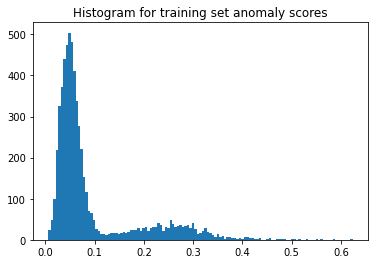

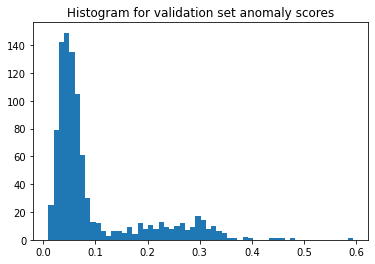

In [46]:
#Attempt theoretical hyperparameters
clf2 = CBLOF(n_clusters=6, alpha=0.5, random_state=42, contamination=outlier_ratio)
clf2.fit(train_arr)
viewOutliers(clf2)

In [47]:
#calculate mean and stdev 
val_score2 = clf2.decision_function(val_arr)
val_normalIndex2 = getNormalIndex(val_state)
val_normalScores2 = getValuebyIndex(val_score2, val_normalIndex2)
valMean2 = statistics.mean(val_normalScores2)
valStdev2 = statistics.stdev(val_normalScores2)
val1Stdev2 = valMean2 + valStdev2
val2Stdev2 = valMean2 + valStdev2*2
    
print('Mean: %.4f. Stdev %.4f. 1 Stdev away: %.4f. 2 Stdev away %.4f.' % (valMean2, valStdev2, val1Stdev2, val2Stdev2))

Mean: 0.0782. Stdev 0.0726. 1 Stdev away: 0.1507. 2 Stdev away 0.2233.


Threshold is 0.130700


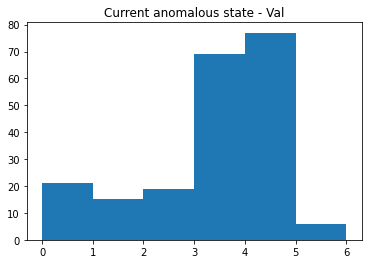

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.400966
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


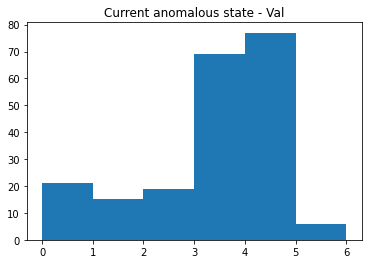

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.734300
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.140700


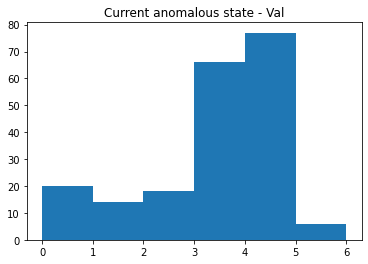

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.412935
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


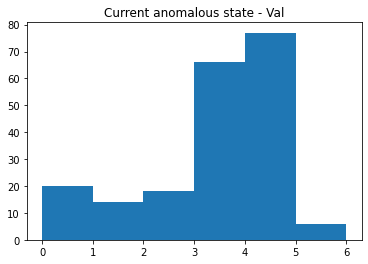

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.741294
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.539855
Threshold is 0.150700


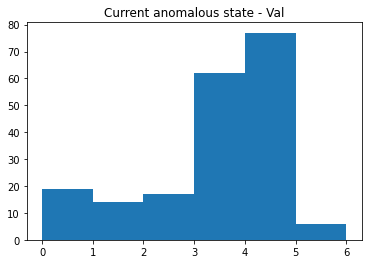

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.425641
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


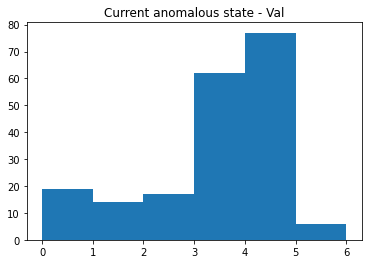

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.743590
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.525362
Threshold is 0.160700


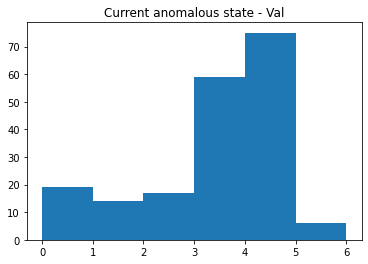

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.426316
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.975904


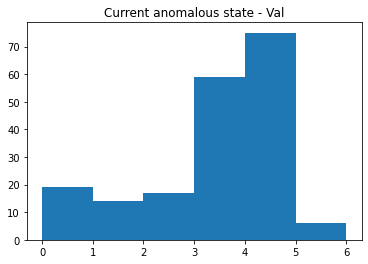

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.736842
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.507246


In [48]:
thresholdTest = [0.1307, 0.1407, 0.1507, 0.1607]
for value in thresholdTest:
    print("Threshold is %f" % value)
    processAnomalyWithoutState3(val_score2, np.array(val_arr), value, 'Val')
    processAnomalyWithState3(val_score2, np.array(val_arr), value, 'Val')

Number of clusters

Number of clusters: 2


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


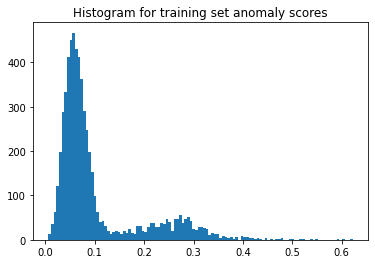

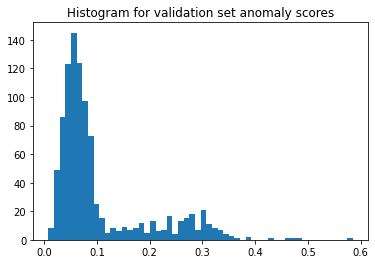

Mean: 0.0866. Stdev 0.0702. 1 Stdev away: 0.1568. 2 Stdev away 0.2270.
Number of clusters: 3


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


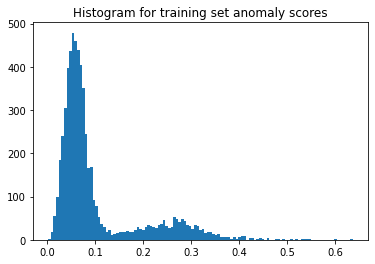

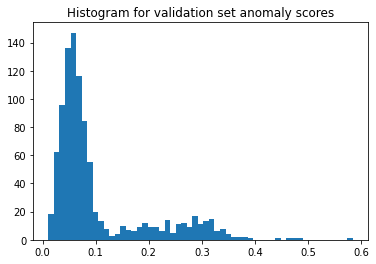

Mean: 0.0854. Stdev 0.0720. 1 Stdev away: 0.1573. 2 Stdev away 0.2293.
Number of clusters: 4


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


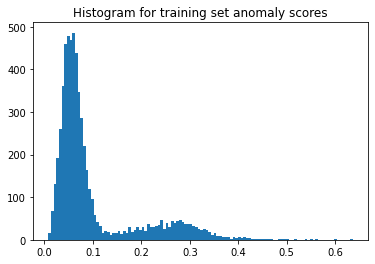

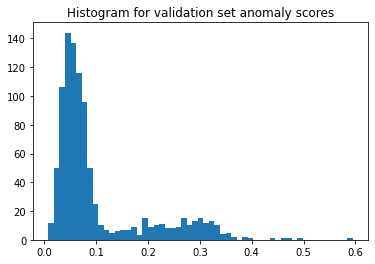

Mean: 0.0849. Stdev 0.0731. 1 Stdev away: 0.1579. 2 Stdev away 0.2310.
Number of clusters: 6


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


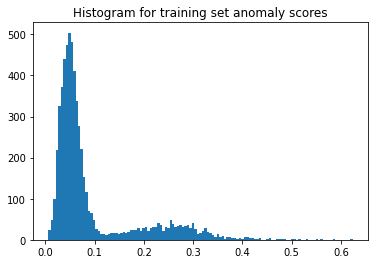

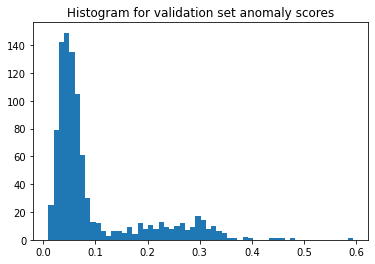

Mean: 0.0782. Stdev 0.0726. 1 Stdev away: 0.1507. 2 Stdev away 0.2233.
Number of clusters: 10


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


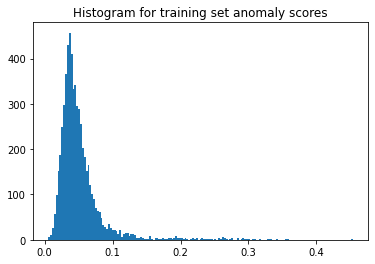

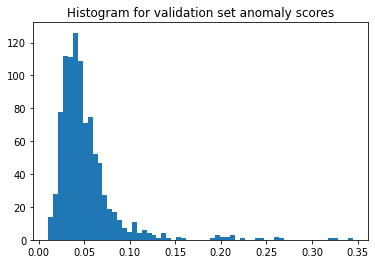

Mean: 0.0488. Stdev 0.0271. 1 Stdev away: 0.0758. 2 Stdev away 0.1029.
Number of clusters: 20


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


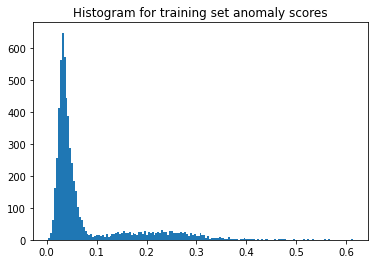

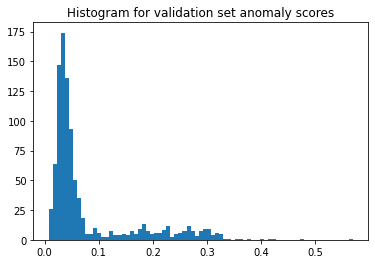

Mean: 0.0627. Stdev 0.0675. 1 Stdev away: 0.1302. 2 Stdev away 0.1977.
Number of clusters: 40


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


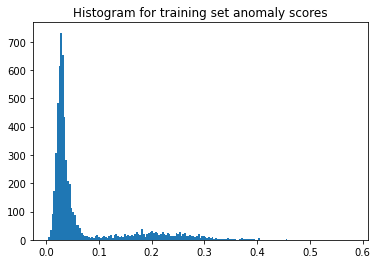

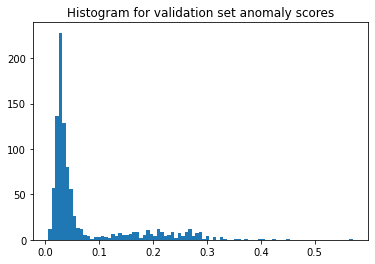

Mean: 0.0564. Stdev 0.0656. 1 Stdev away: 0.1221. 2 Stdev away 0.1877.
Number of clusters: 80


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


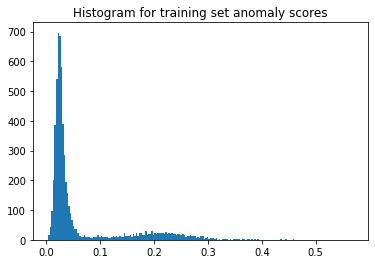

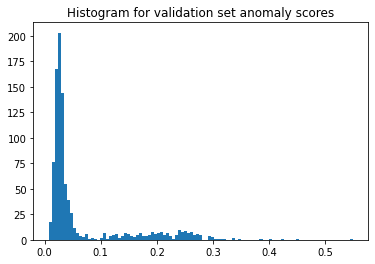

Mean: 0.0516. Stdev 0.0635. 1 Stdev away: 0.1151. 2 Stdev away 0.1787.
Number of clusters: 150


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


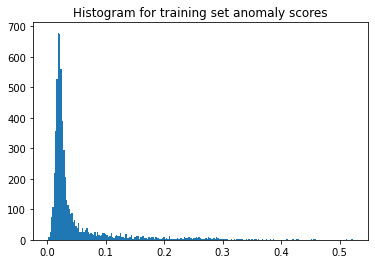

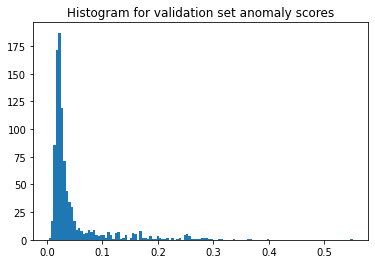

Mean: 0.0408. Stdev 0.0491. 1 Stdev away: 0.0899. 2 Stdev away 0.1390.
Number of clusters: 300


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


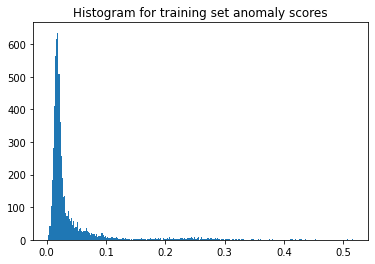

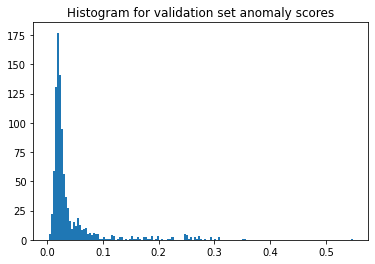

Mean: 0.0346. Stdev 0.0433. 1 Stdev away: 0.0779. 2 Stdev away 0.1213.


In [50]:
#Tune number of clusters 
n_clusters_list = [2, 3, 4, 6, 10, 20, 40, 80, 150, 300]
for c in n_clusters_list:
    print("Number of clusters: %d" % c)
    clf3 = CBLOF(n_clusters=c, alpha=0.75, random_state=42, contamination=outlier_ratio)
    clf3.fit(train_arr)
    viewOutliers(clf3)
    
    #calculate mean and stdev 
    val_score3 = clf3.decision_function(val_arr)
    val_normalIndex3 = getNormalIndex(val_state)
    val_normalScores3 = getValuebyIndex(val_score3, val_normalIndex3)
    valMean3 = statistics.mean(val_normalScores3)
    valStdev3 = statistics.stdev(val_normalScores3)
    val1Stdev3 = valMean3 + valStdev3
    val2Stdev3 = valMean3 + valStdev3*2
    
    print('Mean: %.4f. Stdev %.4f. 1 Stdev away: %.4f. 2 Stdev away %.4f.' % (valMean3, valStdev3, val1Stdev3, val2Stdev3))

In [57]:
thresholdArr3 = [[0.1368, 0.1468, 0.1568, 0.1668, 0.1768],
               [0.1373, 0.1473, 0.1573, 0.1673, 0.1773],
               [0.1379, 0.1479, 0.1579, 0.1679, 0.1779],
               [0.1307, 0.1407, 0.1507, 0.1607, 0.1707],
               [0.0558, 0.0658, 0.0758, 0.0858, 0.0958],
                [0.1102, 0.1202, 0.1302, 0.1402, 0.1502],
                [0.1021, 0.1121, 0.1221, 0.1321, 0.1421],
                [0.0951, 0.1051, 0.1151, 0.1251, 0.1351],
                [0.0699, 0.0799, 0.0899, 0.0999, 0.1099],
                [0.0599, 0.0699, 0.0799, 0.0899, 0.0999]]

In [58]:
thresholdArr3

[[0.1368, 0.1468, 0.1568, 0.1668, 0.1768],
 [0.1373, 0.1473, 0.1573, 0.1673, 0.1773],
 [0.1379, 0.1479, 0.1579, 0.1679, 0.1779],
 [0.1307, 0.1407, 0.1507, 0.1607, 0.1707],
 [0.0558, 0.0658, 0.0758, 0.0858, 0.0958],
 [0.1102, 0.1202, 0.1302, 0.1402, 0.1502],
 [0.1021, 0.1121, 0.1221, 0.1321, 0.1421],
 [0.0951, 0.1051, 0.1151, 0.1251, 0.1351],
 [0.0699, 0.0799, 0.0899, 0.0999, 0.1099],
 [0.0599, 0.0699, 0.0799, 0.0899, 0.0999]]

Number of clusters: 2
Threshold is 0.136800


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


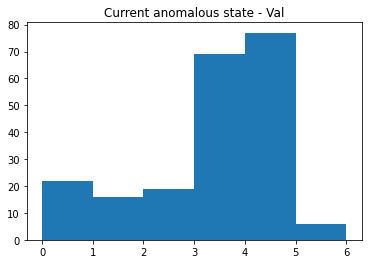

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.397129
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


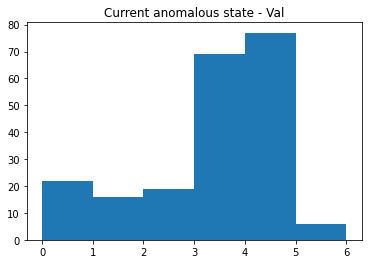

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.727273
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.146800


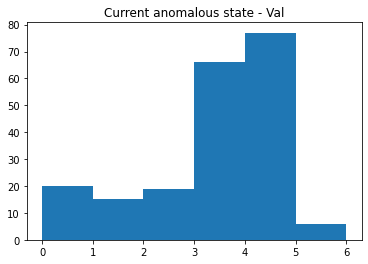

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.408867
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


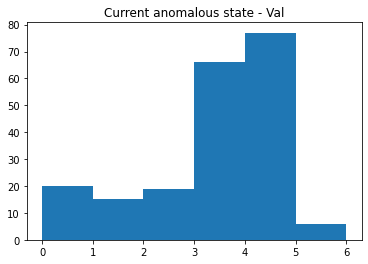

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.733990
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.539855
Threshold is 0.156800


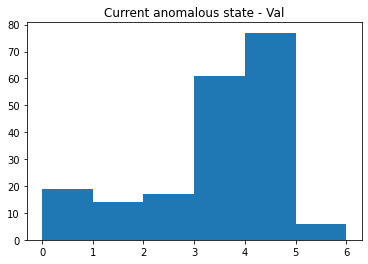

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.427835
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


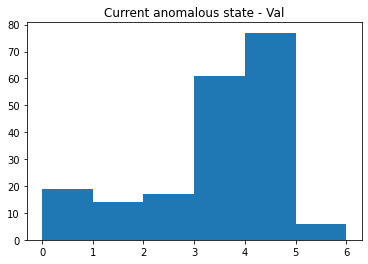

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.742268
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.521739
Threshold is 0.166800


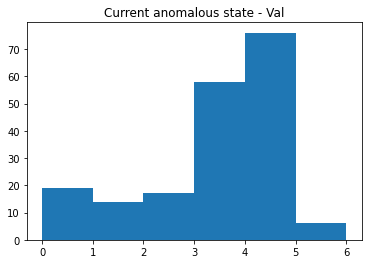

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.431579
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


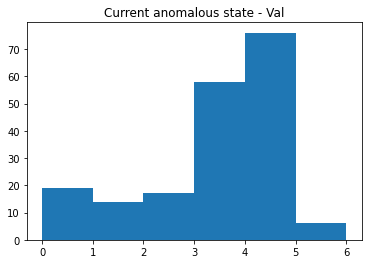

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.736842
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.507246
Threshold is 0.176800


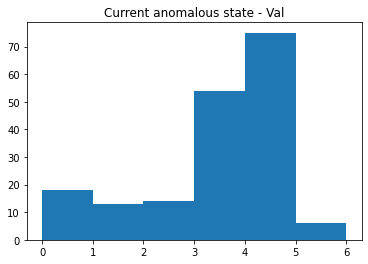

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.450000
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.975904


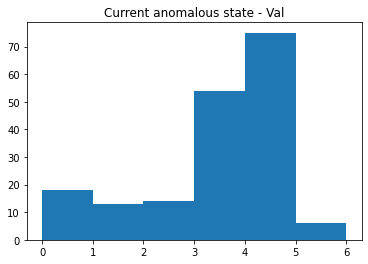

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.750000
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.489130
Number of clusters: 3
Threshold is 0.137300


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


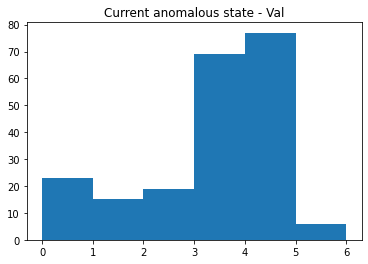

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.397129
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


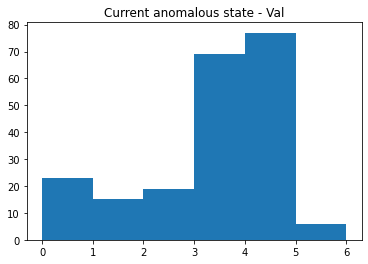

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.727273
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.147300


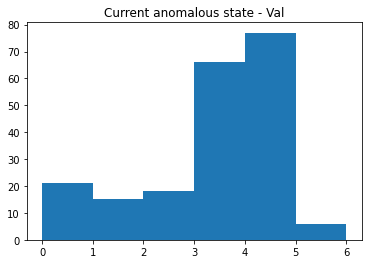

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.408867
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


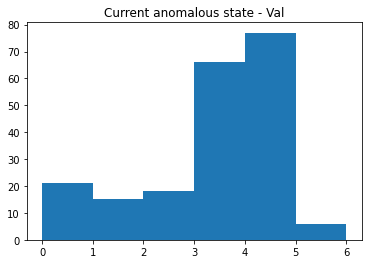

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.733990
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.539855
Threshold is 0.157300


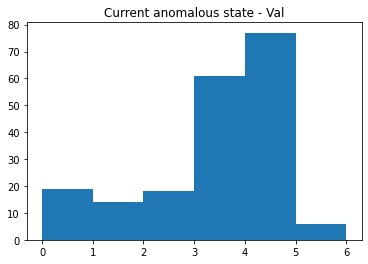

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.425641
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


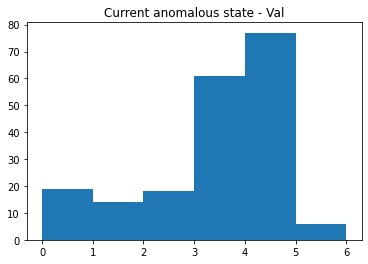

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.738462
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.521739
Threshold is 0.167300


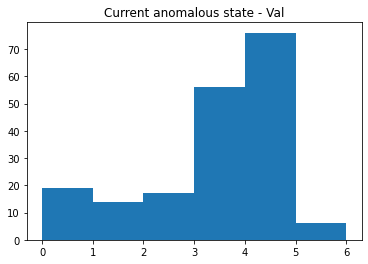

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.436170
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


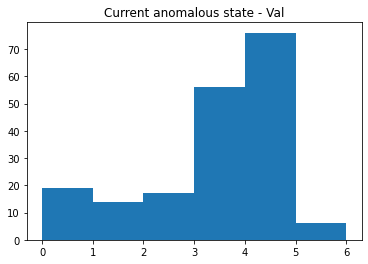

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.734043
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.500000
Threshold is 0.177300


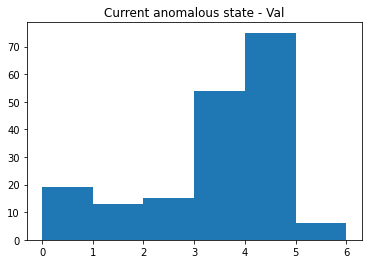

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.445055
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.975904


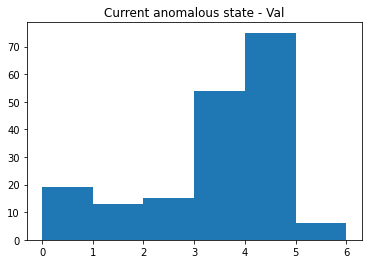

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.741758
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.489130
Number of clusters: 4


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Threshold is 0.137900


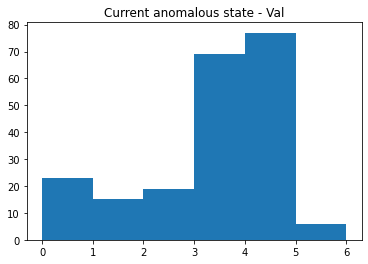

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.397129
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


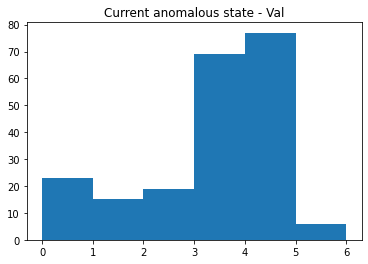

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.727273
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.147900


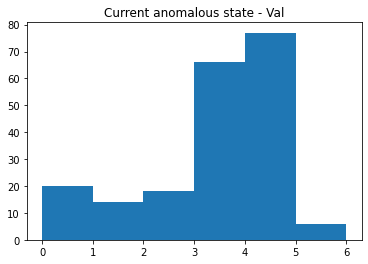

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.412935
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


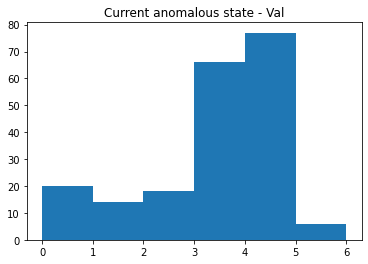

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.741294
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.539855
Threshold is 0.157900


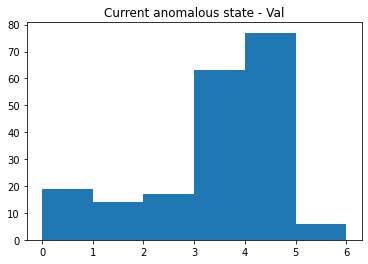

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.423469
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


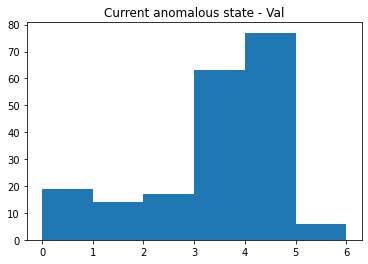

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.744898
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.528986
Threshold is 0.167900


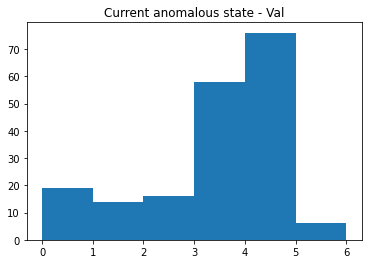

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.433862
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


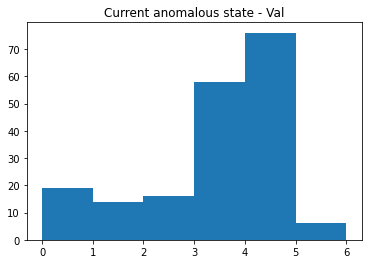

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.740741
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.507246
Threshold is 0.177900


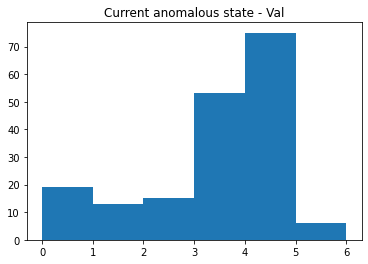

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.447514
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.975904


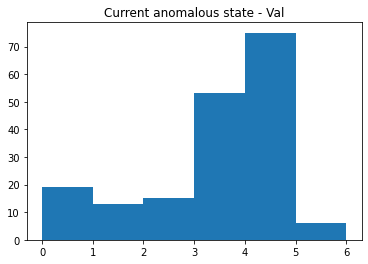

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.740331
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.485507
Number of clusters: 6


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Threshold is 0.130700


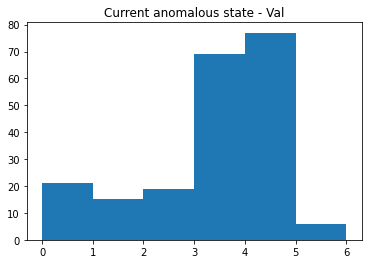

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.400966
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


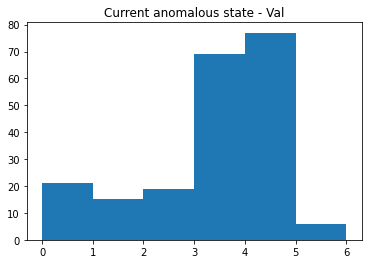

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.734300
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.140700


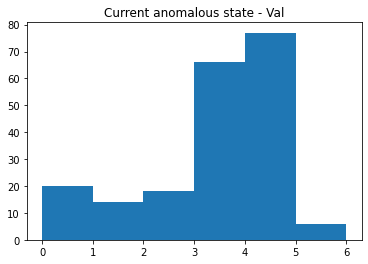

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.412935
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


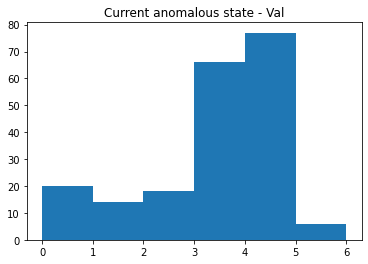

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.741294
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.539855
Threshold is 0.150700


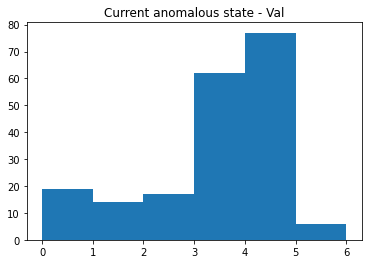

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.425641
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


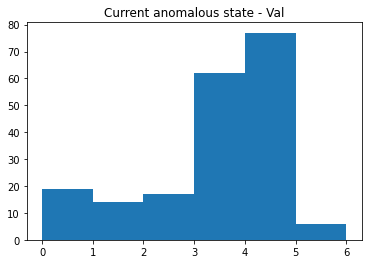

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.743590
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.525362
Threshold is 0.160700


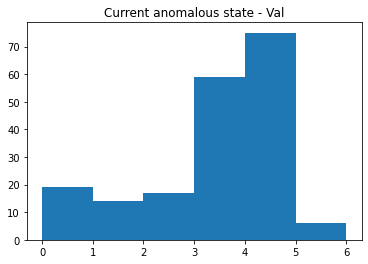

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.426316
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.975904


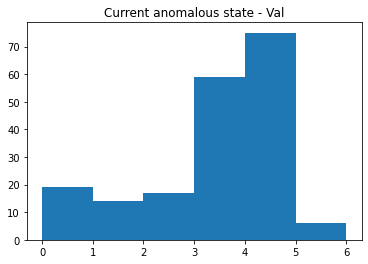

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.736842
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.507246
Threshold is 0.170700


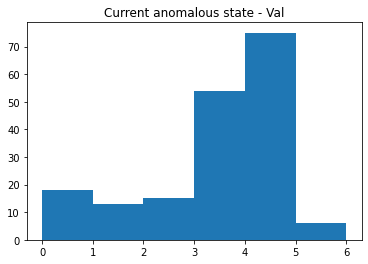

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.447514
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.975904


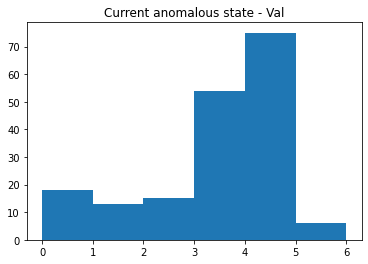

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.745856
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.489130
Number of clusters: 10


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Threshold is 0.055800


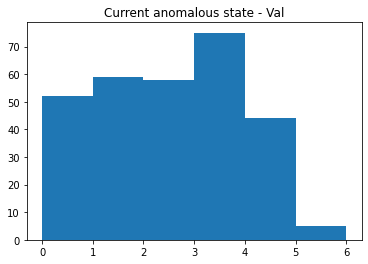

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.167235
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.590361


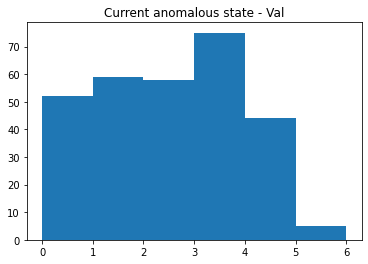

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.423208
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.449275
Threshold is 0.065800


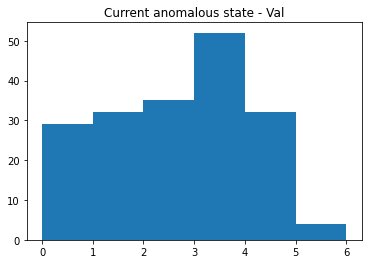

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.195652
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.433735


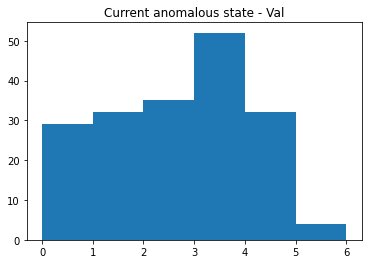

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.478261
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.318841
Threshold is 0.075800


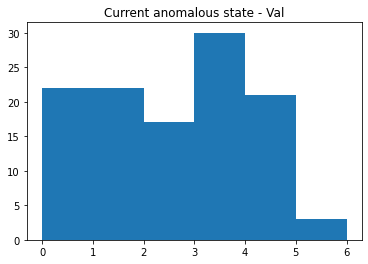

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.208696
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.289157


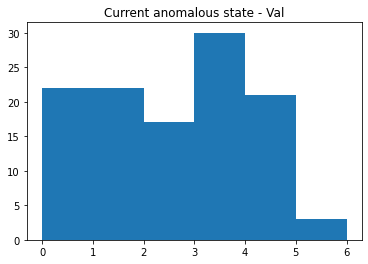

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.469565
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.195652
Threshold is 0.085800


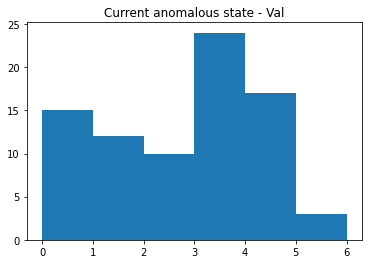

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.246914
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.240964


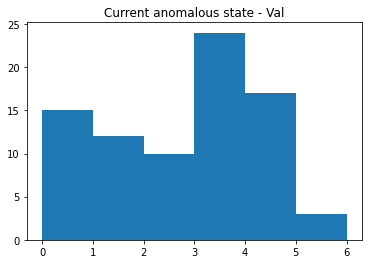

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.543210
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.159420
Threshold is 0.095800


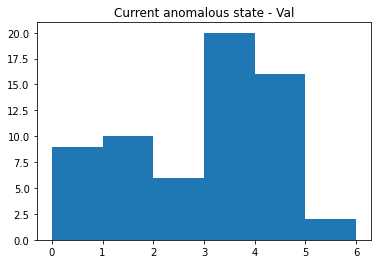

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.285714
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.216867


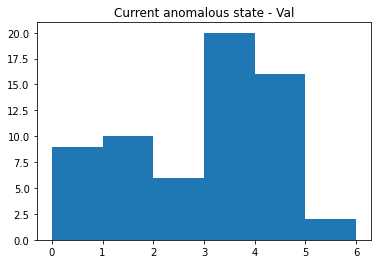

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.603175
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.137681
Number of clusters: 20


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Threshold is 0.110200


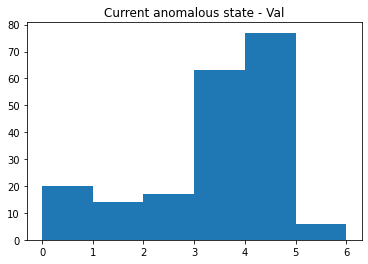

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.421320
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


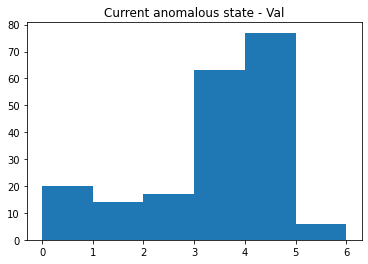

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.741117
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.528986
Threshold is 0.120200


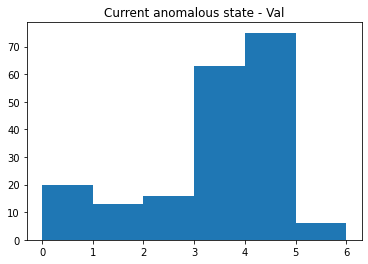

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.419689
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.975904


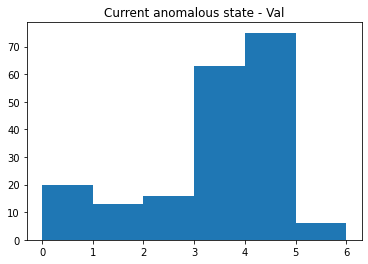

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.746114
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.521739
Threshold is 0.130200


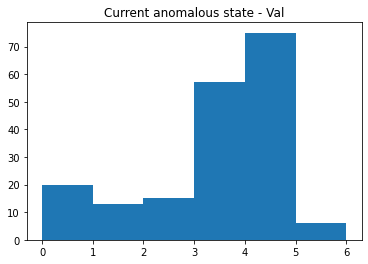

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.435484
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.975904


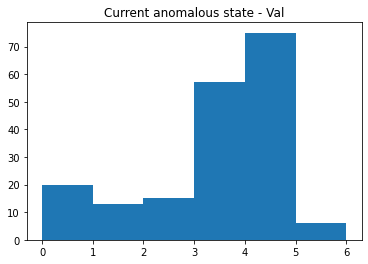

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.741935
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.500000
Threshold is 0.140200


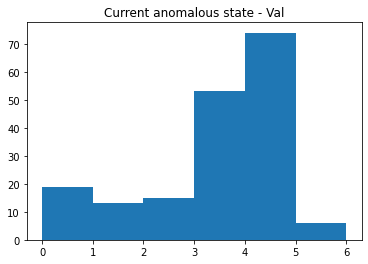

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.444444
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.963855


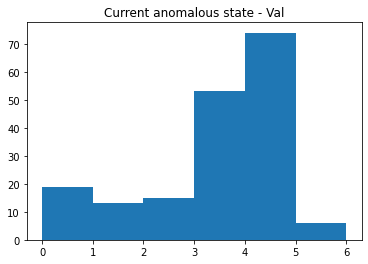

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.738889
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.481884
Threshold is 0.150200


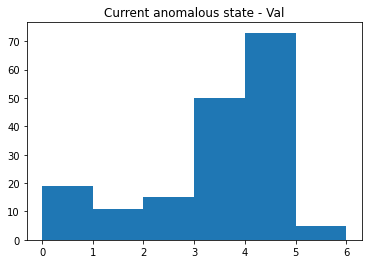

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.450867
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.939759


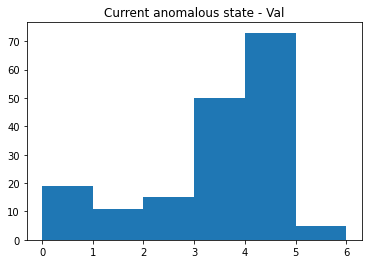

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.739884
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.463768
Number of clusters: 40


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Threshold is 0.102100


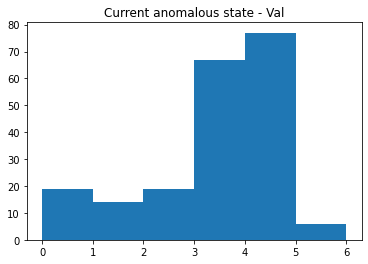

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.410891
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


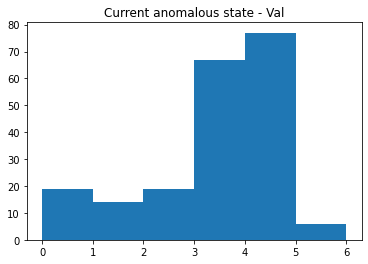

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.742574
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.543478
Threshold is 0.112100


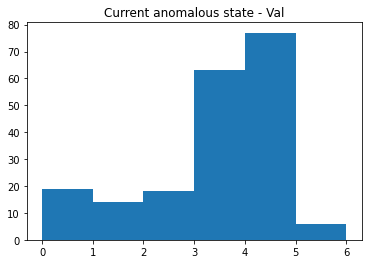

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.421320
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


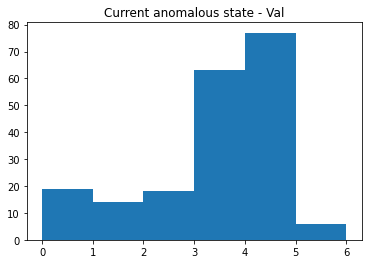

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.741117
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.528986
Threshold is 0.122100


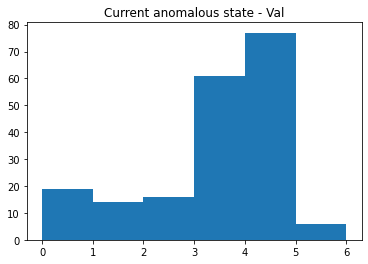

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.430052
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


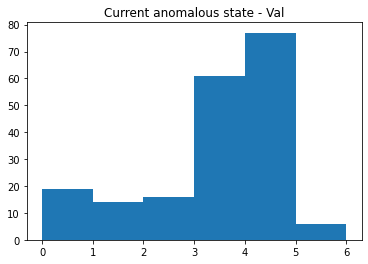

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.746114
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.521739
Threshold is 0.132100


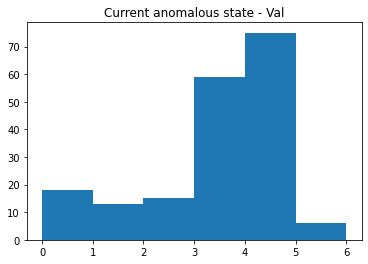

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.435484
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.975904


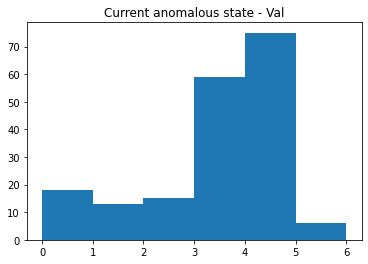

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.752688
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.507246
Threshold is 0.142100


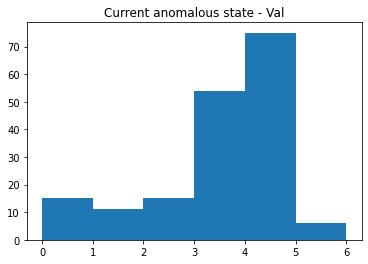

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.460227
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.975904


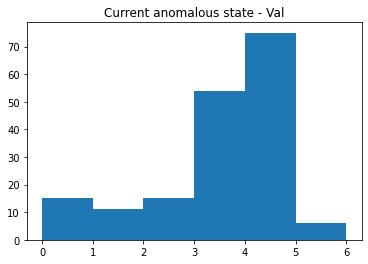

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.767045
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.489130
Number of clusters: 80


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Threshold is 0.095100


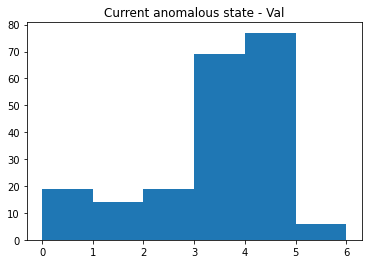

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.406863
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


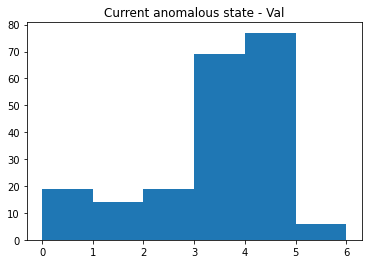

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.745098
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.105100


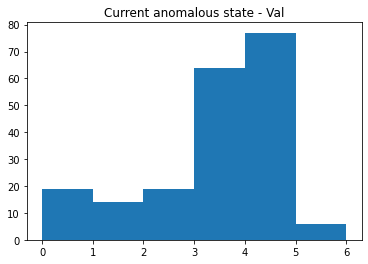

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.417085
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


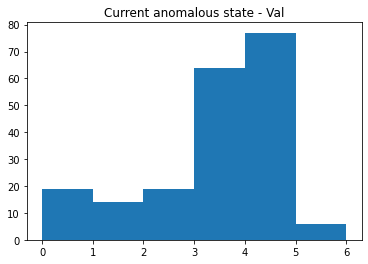

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.738693
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.532609
Threshold is 0.115100


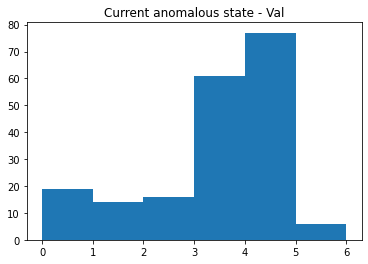

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.430052
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


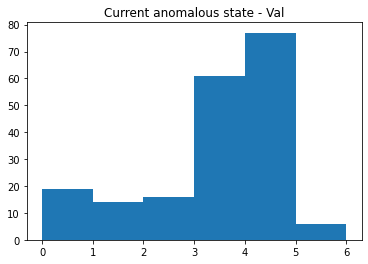

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.746114
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.521739
Threshold is 0.125100


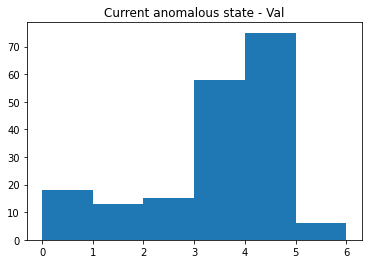

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.437838
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.975904


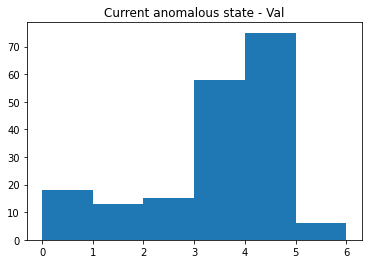

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.751351
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.503623
Threshold is 0.135100


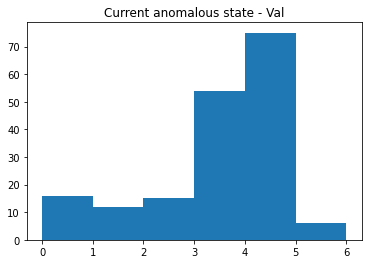

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.455056
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.975904


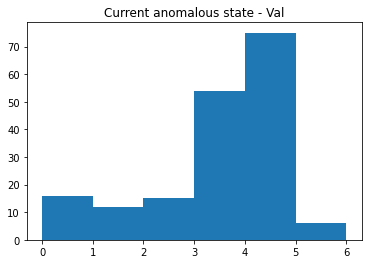

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.758427
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.489130
Number of clusters: 150


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Threshold is 0.069900


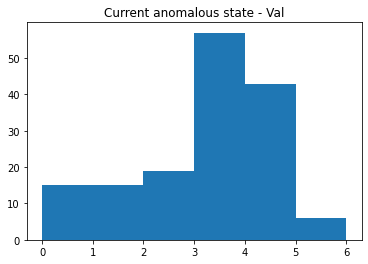

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.316129
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.590361


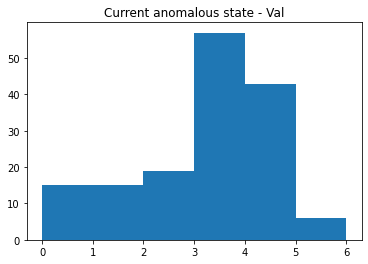

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.683871
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.384058
Threshold is 0.079900


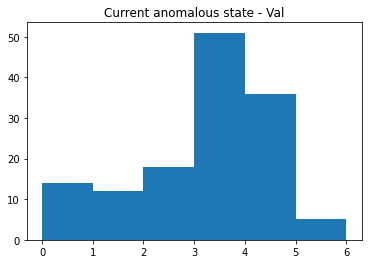

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.301471
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.493976


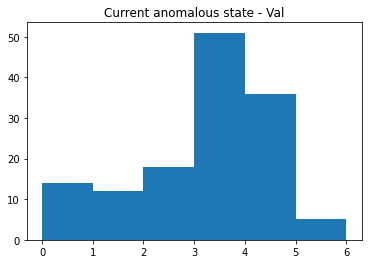

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.676471
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.333333
Threshold is 0.089900


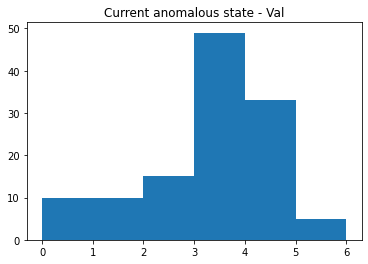

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.311475
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.457831


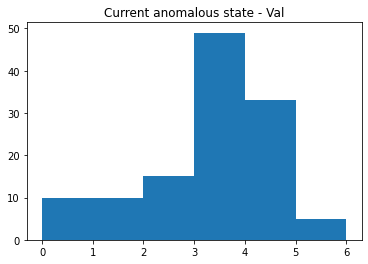

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.713115
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.315217
Threshold is 0.099900


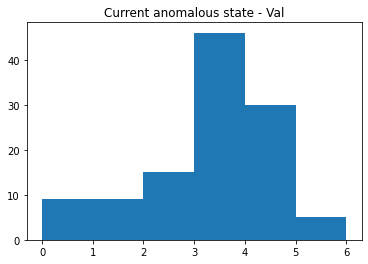

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.307018
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.421687


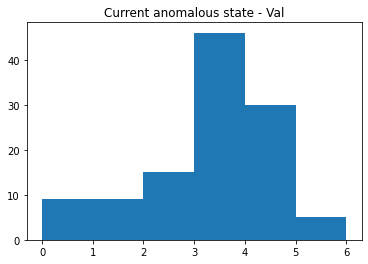

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.710526
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.293478
Threshold is 0.109900


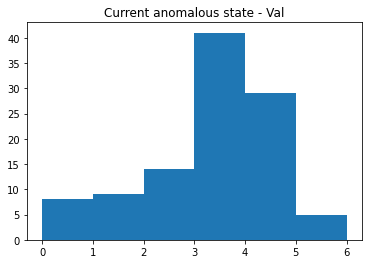

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.320755
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.409639


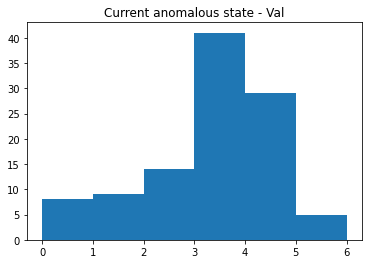

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.707547
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.271739
Number of clusters: 300


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Threshold is 0.059900


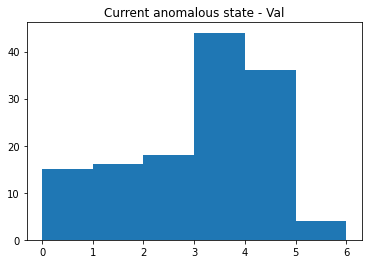

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.300752
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.481928


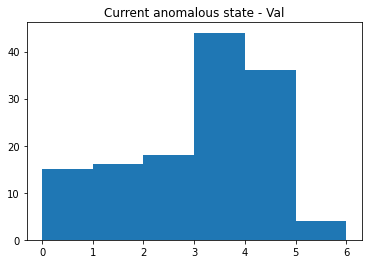

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.631579
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.304348
Threshold is 0.069900


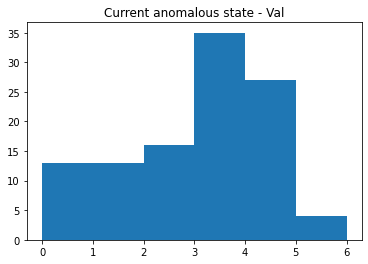

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.287037
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.373494


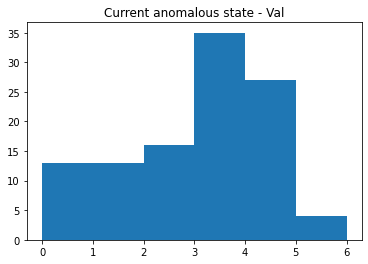

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.611111
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.239130
Threshold is 0.079900


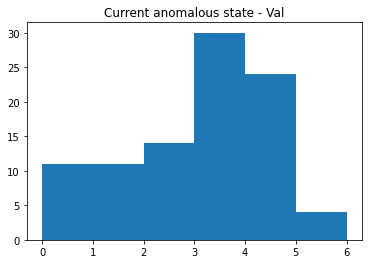

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.297872
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.337349


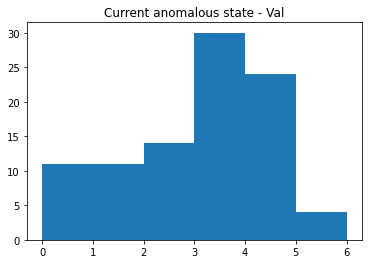

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.617021
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.210145
Threshold is 0.089900


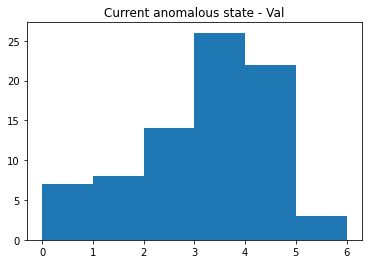

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.312500
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.301205


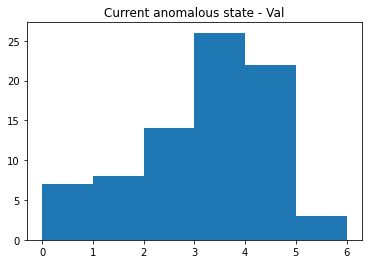

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.637500
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.184783
Threshold is 0.099900


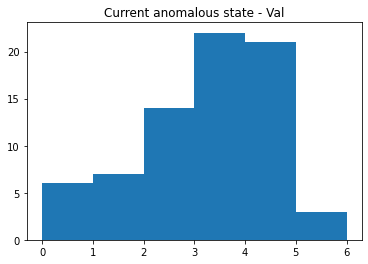

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.328767
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.289157


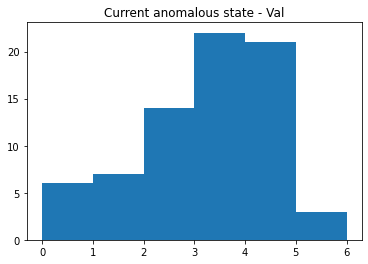

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.630137
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.166667


In [59]:
n_clusters_list = [2, 3, 4, 6, 10, 20, 40, 80, 150, 300]
for order in range(len(n_clusters_list)):
    n_cluster = n_clusters_list[order]
    print("Number of clusters: %d" % n_cluster)
    clf3 = CBLOF(n_clusters=n_cluster, alpha=0.75, random_state=42, contamination=outlier_ratio)
    clf3.fit(train_arr)
    
    threshold_test = thresholdArr3[order]
    val_score3 = clf3.decision_function(val_arr)
    
    for value in threshold_test:
        print("Threshold is %f" % value)
        processAnomalyWithoutState3(val_score3, np.array(val_arr), value, 'Val')
        processAnomalyWithState3(val_score3, np.array(val_arr), value, 'Val')

n_clusters=40 seems to give the best performance

Tune alpha

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of alpha: 0.500000


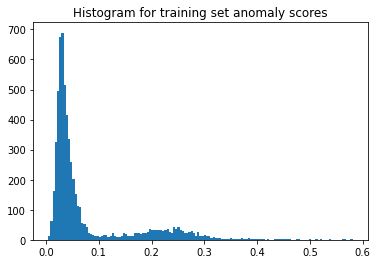

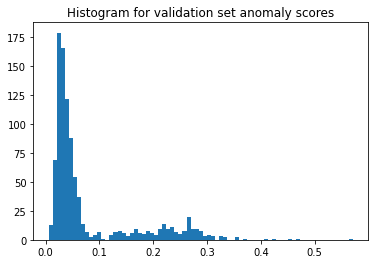

Mean: 0.0613. Stdev 0.0674. 1 Stdev away: 0.1287. 2 Stdev away 0.1961.


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of alpha: 0.600000


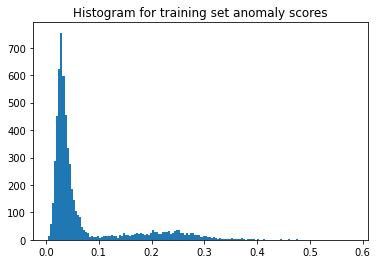

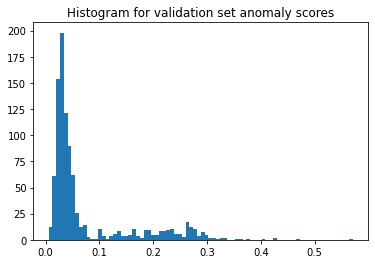

Mean: 0.0592. Stdev 0.0664. 1 Stdev away: 0.1257. 2 Stdev away 0.1921.


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of alpha: 0.700000


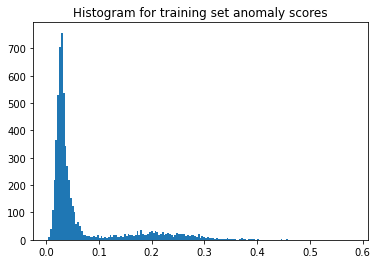

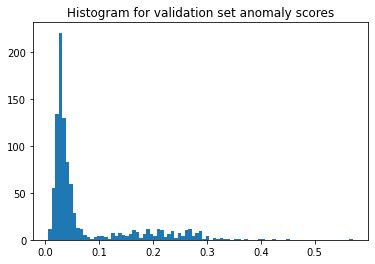

Mean: 0.0568. Stdev 0.0657. 1 Stdev away: 0.1225. 2 Stdev away 0.1881.


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of alpha: 0.800000


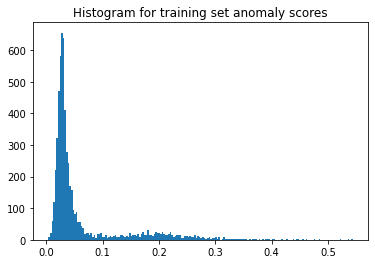

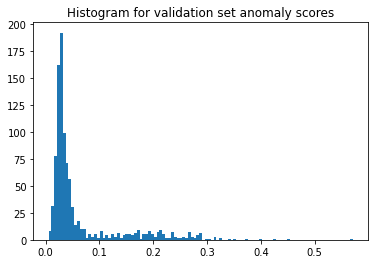

Mean: 0.0511. Stdev 0.0568. 1 Stdev away: 0.1079. 2 Stdev away 0.1646.


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of alpha: 0.900000


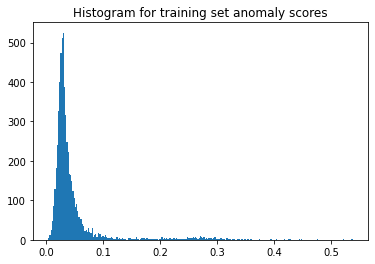

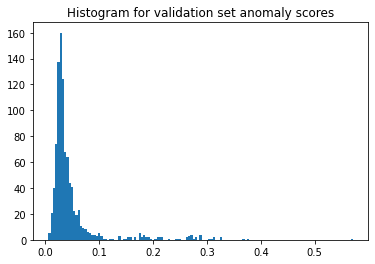

Mean: 0.0433. Stdev 0.0443. 1 Stdev away: 0.0877. 2 Stdev away 0.1320.


In [61]:
#Tune alpha 
alpha_list = [0.5, 0.6, 0.7, 0.8, 0.9]
for a in alpha_list:
    clf4 = CBLOF(n_clusters=40, alpha=a, random_state=42, contamination=outlier_ratio)
    clf4.fit(train_arr)
    print("Value of alpha: %f" % a)
    viewOutliers(clf4)
    
    #calculate mean and stdev 
    val_score4 = clf4.decision_function(val_arr)
    val_normalIndex4 = getNormalIndex(val_state)
    val_normalScores4 = getValuebyIndex(val_score4, val_normalIndex4)
    valMean4 = statistics.mean(val_normalScores4)
    valStdev4 = statistics.stdev(val_normalScores4)
    val1Stdev4 = valMean4 + valStdev4
    val2Stdev4 = valMean4 + valStdev4*2
    
    print('Mean: %.4f. Stdev %.4f. 1 Stdev away: %.4f. 2 Stdev away %.4f.' % (valMean4, valStdev4, val1Stdev4, val2Stdev4))

In [62]:
thresholdArr4 = [[0.1087, 0.1187, 0.1287, 0.1387, 0.1487],
               [0.1057, 0.1157, 0.1257, 0.1357, 0.1457],
               [0.1025, 0.1125, 0.1225, 0.1325, 0.1425],
               [0.0879, 0.0979, 0.1079, 0.1179, 0.1279],
               [0.0677, 0.0777, 0.0877, 0.0977, 0.1077]]

In [64]:
thresholdArr4

[[0.1087, 0.1187, 0.1287, 0.1387, 0.1487],
 [0.1057, 0.1157, 0.1257, 0.1357, 0.1457],
 [0.1025, 0.1125, 0.1225, 0.1325, 0.1425],
 [0.0879, 0.0979, 0.1079, 0.1179, 0.1279],
 [0.0677, 0.0777, 0.0877, 0.0977, 0.1077]]

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of alpha: 0.500000
Threshold is 0.108700


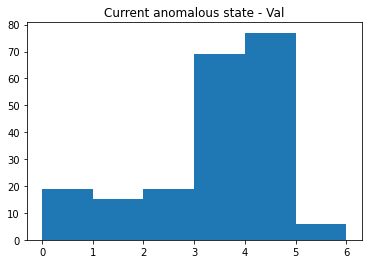

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.404878
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


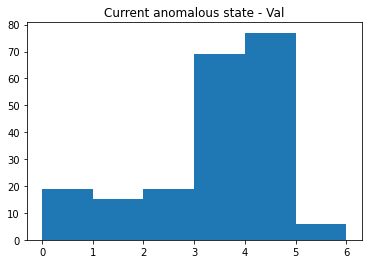

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.741463
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.118700


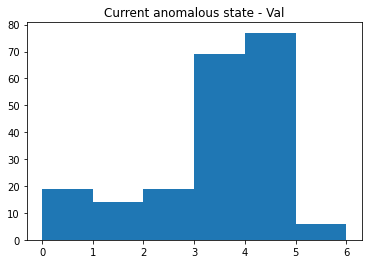

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.406863
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


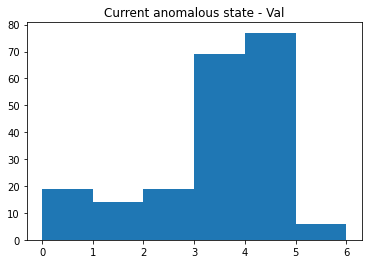

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.745098
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.128700


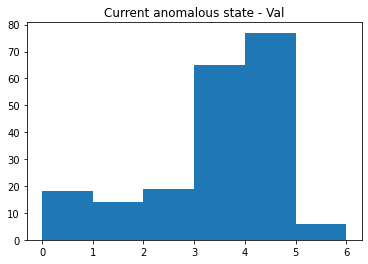

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.417085
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


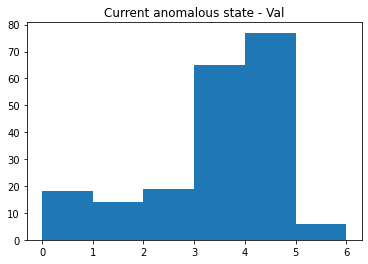

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.743719
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.536232
Threshold is 0.138700


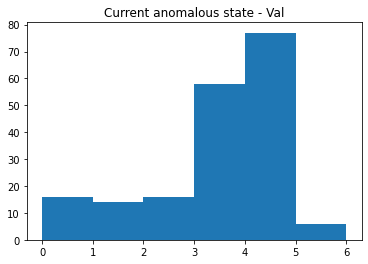

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.443850
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


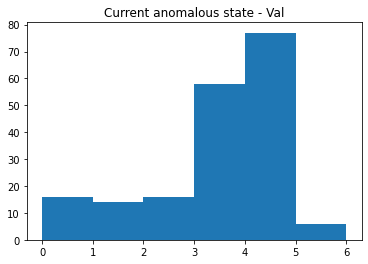

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.754011
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.510870
Threshold is 0.148700


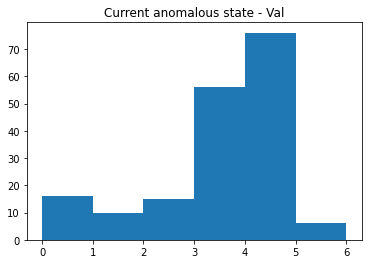

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.458101
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


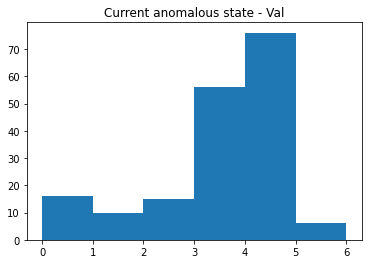

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.770950
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.500000


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of alpha: 0.600000
Threshold is 0.105700


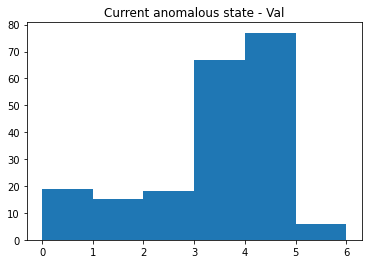

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.410891
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


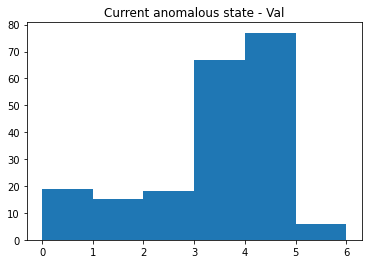

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.742574
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.543478
Threshold is 0.115700


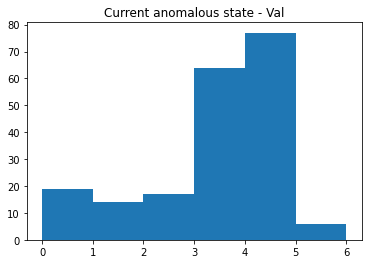

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.421320
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


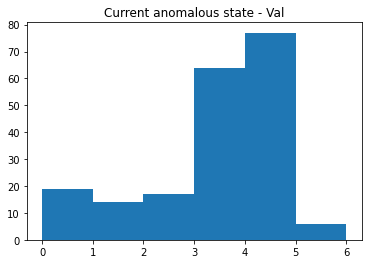

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.746193
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.532609
Threshold is 0.125700


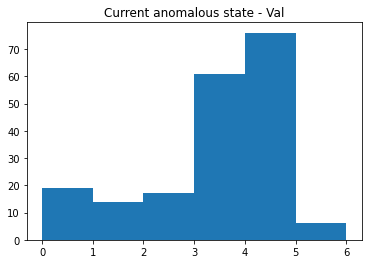

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.424870
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


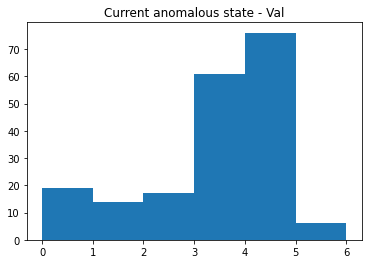

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.740933
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.518116
Threshold is 0.135700


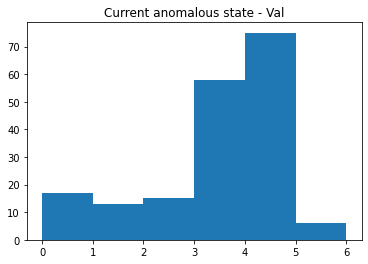

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.440217
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.975904


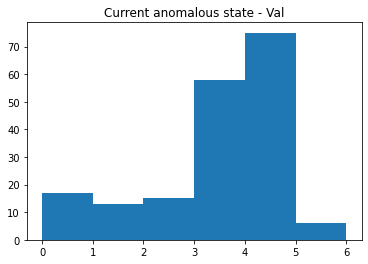

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.755435
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.503623
Threshold is 0.145700


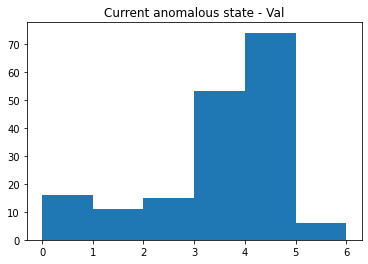

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.457143
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.963855


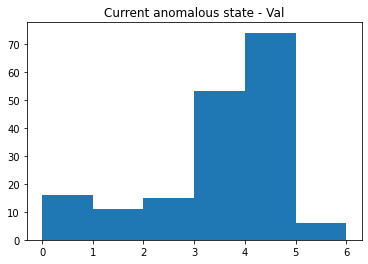

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.760000
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.481884


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of alpha: 0.700000
Threshold is 0.102500


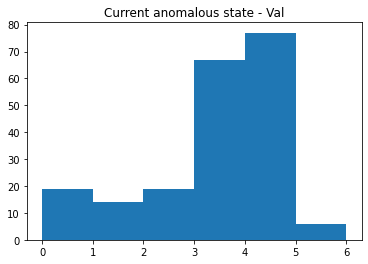

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.410891
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


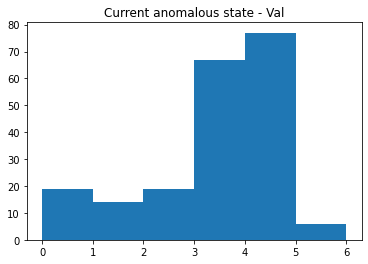

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.742574
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.543478
Threshold is 0.112500


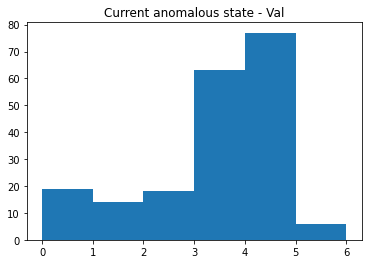

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.421320
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


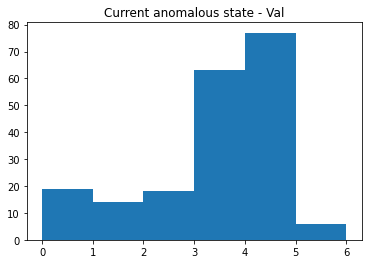

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.741117
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.528986
Threshold is 0.122500


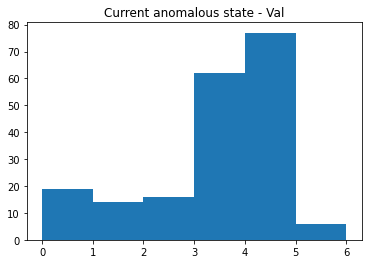

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.427835
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


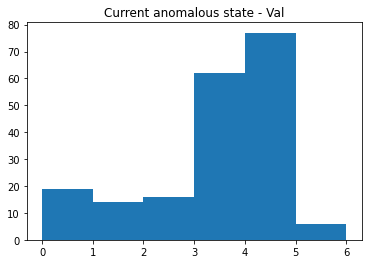

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.747423
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.525362
Threshold is 0.132500


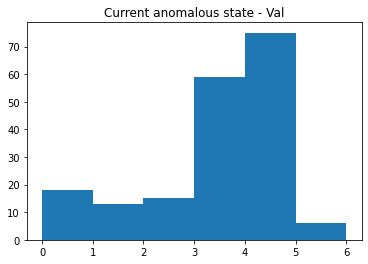

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.435484
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.975904


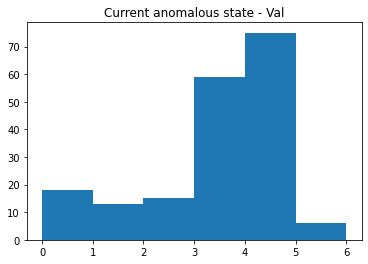

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.752688
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.507246
Threshold is 0.142500


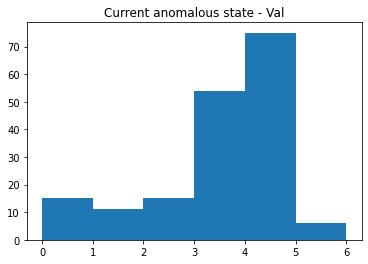

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.460227
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.975904


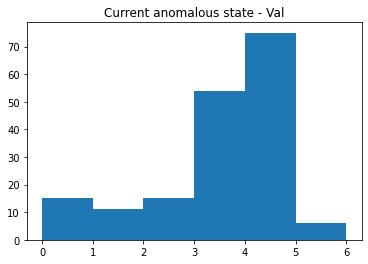

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.767045
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.489130


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of alpha: 0.800000
Threshold is 0.087900


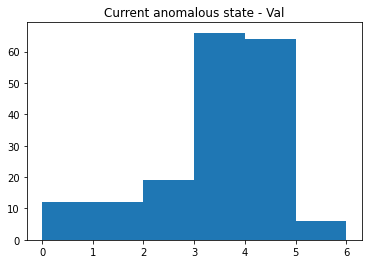

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.391061
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.843373


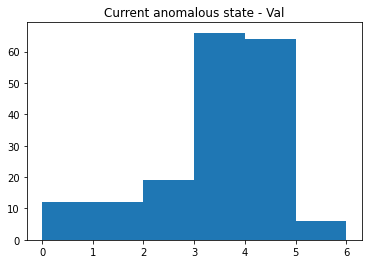

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.759777
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.492754
Threshold is 0.097900


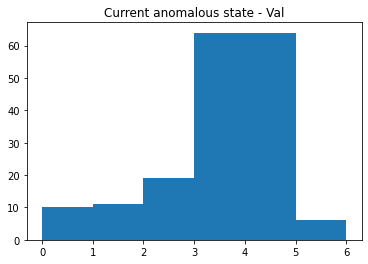

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.402299
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.843373


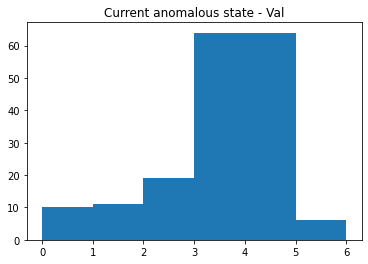

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.770115
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.485507
Threshold is 0.107900


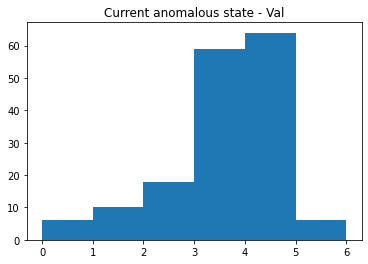

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.429448
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.843373


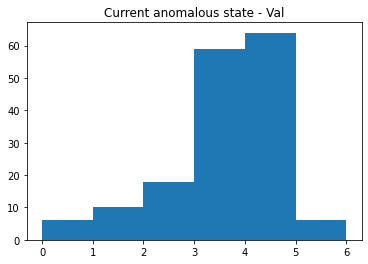

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.791411
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.467391
Threshold is 0.117900


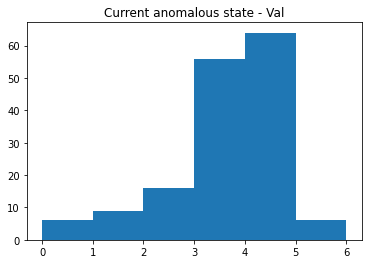

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.445860
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.843373


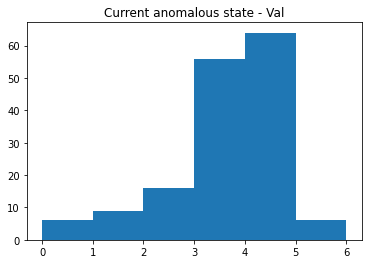

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.802548
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.456522
Threshold is 0.127900


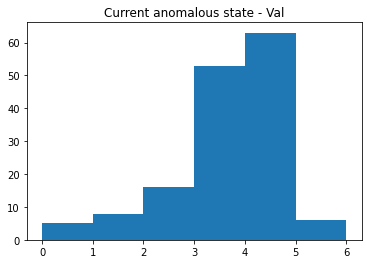

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.456954
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.831325


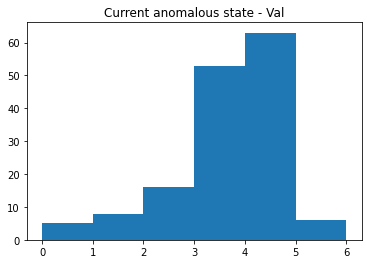

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.807947
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.442029


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of alpha: 0.900000
Threshold is 0.067700


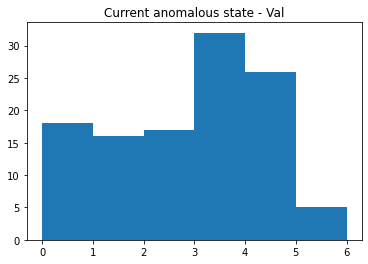

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.271930
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.373494


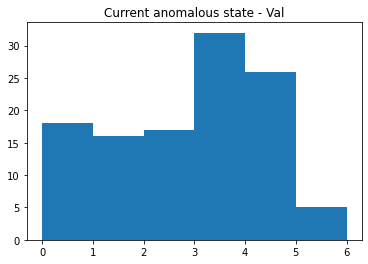

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.552632
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.228261
Threshold is 0.077700


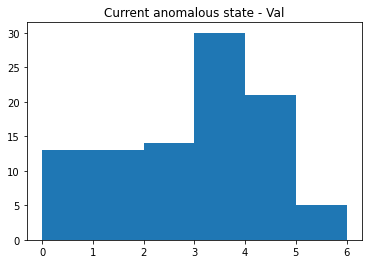

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.270833
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.313253


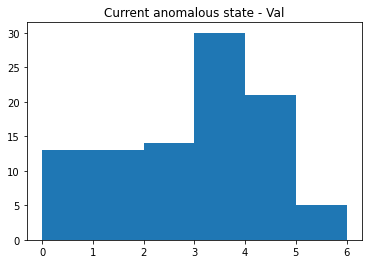

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.583333
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.202899
Threshold is 0.087700


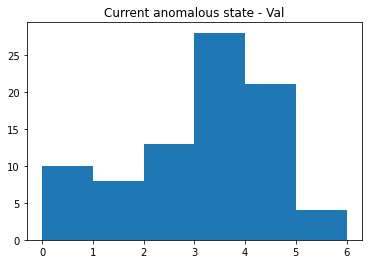

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.297619
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.301205


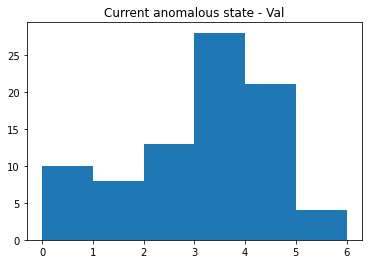

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.630952
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.192029
Threshold is 0.097700


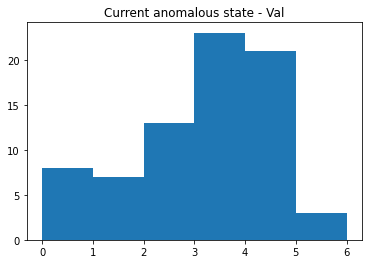

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.320000
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.289157


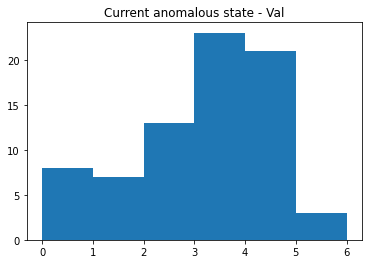

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.626667
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.170290
Threshold is 0.107700


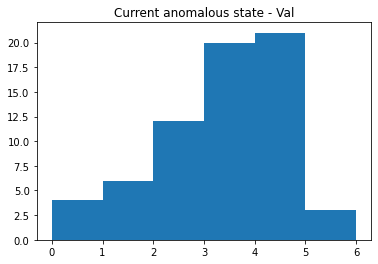

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.363636
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.289157


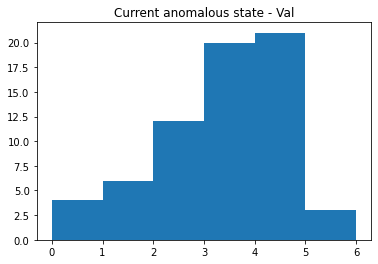

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.666667
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.159420


In [66]:
#Tune alpha 
alpha_list = [0.5, 0.6, 0.7, 0.8, 0.9]
for order in range(len(alpha_list)):
    a = alpha_list[order]
    clf4 = CBLOF(n_clusters=40, alpha=a, random_state=42, contamination=outlier_ratio)
    clf4.fit(train_arr)
    print("Value of alpha: %f" % a)
    
    threshold_test = thresholdArr4[order]
    val_score4 = clf4.decision_function(val_arr)
    
    for value in threshold_test:
        print("Threshold is %f" % value)
        processAnomalyWithoutState3(val_score4, np.array(val_arr), value, 'Val')
        processAnomalyWithState3(val_score4, np.array(val_arr), value, 'Val')

alpha=0.5 gave the best results

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of beta: 2


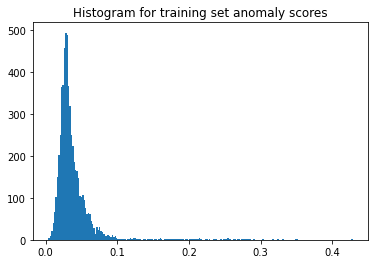

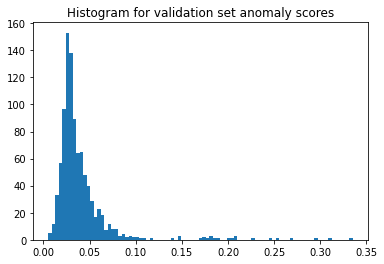

Mean: 0.0366. Stdev 0.0231. 1 Stdev away: 0.0597. 2 Stdev away 0.0828.


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of beta: 4


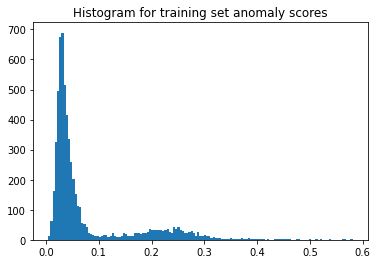

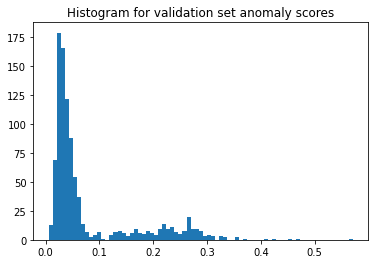

Mean: 0.0613. Stdev 0.0674. 1 Stdev away: 0.1287. 2 Stdev away 0.1961.


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of beta: 8


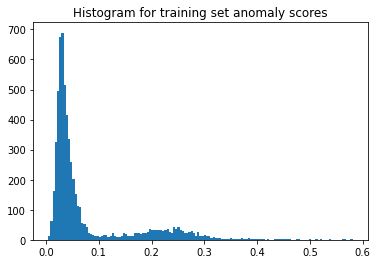

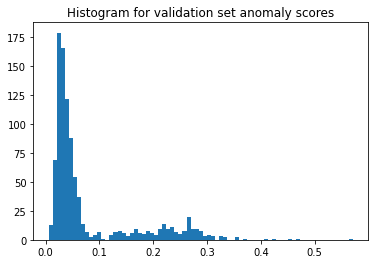

Mean: 0.0613. Stdev 0.0674. 1 Stdev away: 0.1287. 2 Stdev away 0.1961.


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of beta: 16


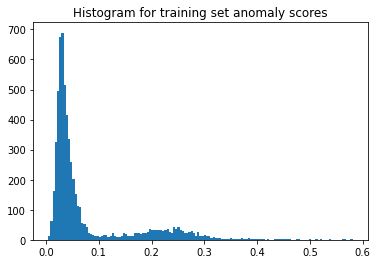

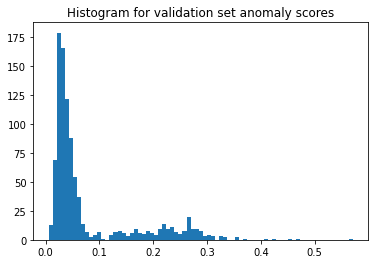

Mean: 0.0613. Stdev 0.0674. 1 Stdev away: 0.1287. 2 Stdev away 0.1961.


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of beta: 24


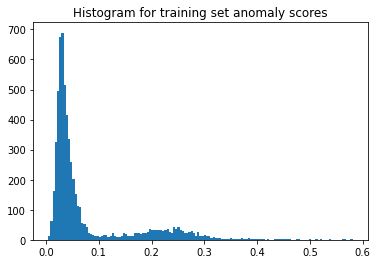

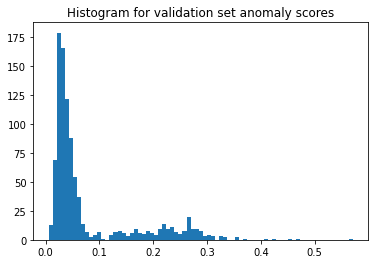

Mean: 0.0613. Stdev 0.0674. 1 Stdev away: 0.1287. 2 Stdev away 0.1961.


In [26]:
import statistics
from pyod.models.cblof import CBLOF

#Tune beta 
beta_list = [2, 4, 8, 16, 24]
for b in beta_list:
    clf5 = CBLOF(n_clusters=40, alpha=0.5, beta=b, random_state=42, contamination=outlier_ratio)
    clf5.fit(train_arr)
    print("Value of beta: %d" % b)
    viewOutliers(clf5)
    
    #calculate mean and stdev 
    val_score5 = clf5.decision_function(val_arr)
    val_normalIndex5 = getNormalIndex(val_state)
    val_normalScores5 = getValuebyIndex(val_score5, val_normalIndex5)
    valMean5 = statistics.mean(val_normalScores5)
    valStdev5 = statistics.stdev(val_normalScores5)
    val1Stdev5 = valMean5 + valStdev5
    val2Stdev5 = valMean5 + valStdev5*2
    
    print('Mean: %.4f. Stdev %.4f. 1 Stdev away: %.4f. 2 Stdev away %.4f.' % (valMean5, valStdev5, val1Stdev5, val2Stdev5))

In [27]:
thresholdArr5 = [[0.0397, 0.0497, 0.0597, 0.0697, 0.0797],
               [0.1087, 0.1187, 0.1287, 0.1387, 0.1487],
               [0.1087, 0.1187, 0.1287, 0.1387, 0.1487],
               [0.1087, 0.1187, 0.1287, 0.1387, 0.1487],
               [0.1087, 0.1187, 0.1287, 0.1387, 0.1487]]

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of beta: 2
Threshold is 0.039700


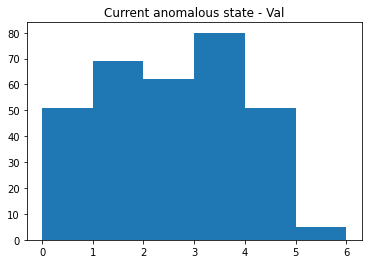

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.176101
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.674699


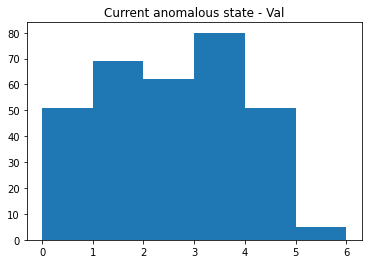

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.427673
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.492754
Threshold is 0.049700


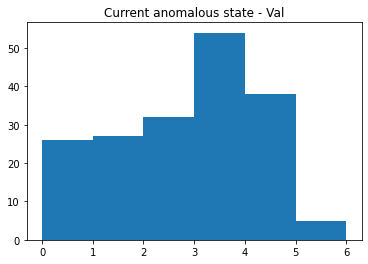

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.236264
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.518072


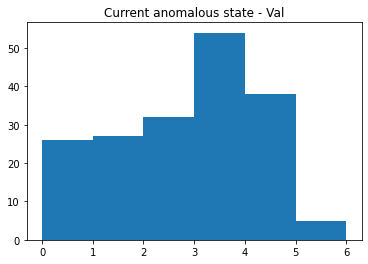

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.532967
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.351449
Threshold is 0.059700


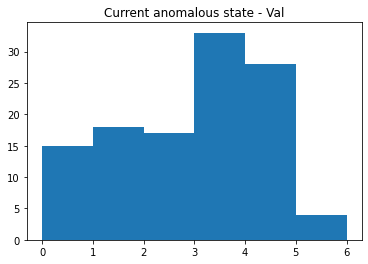

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.278261
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.385542


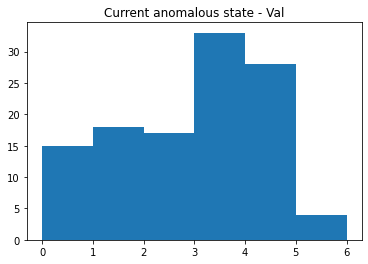

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.565217
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.235507
Threshold is 0.069700


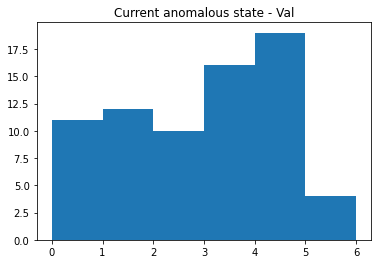

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.319444
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.277108


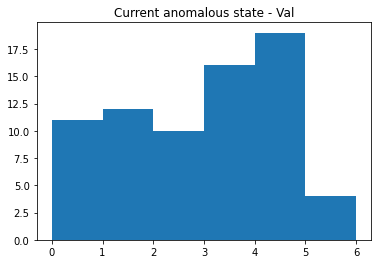

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.541667
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.141304
Threshold is 0.079700


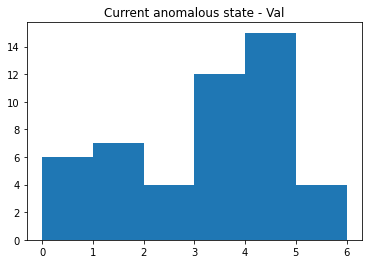

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.395833
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.228916


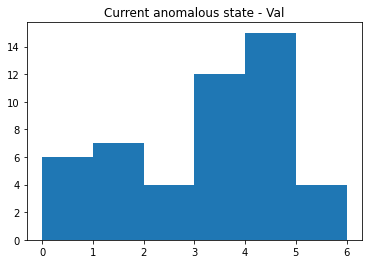

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.645833
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.112319


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of beta: 4
Threshold is 0.108700


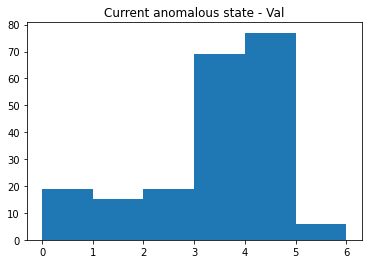

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.404878
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


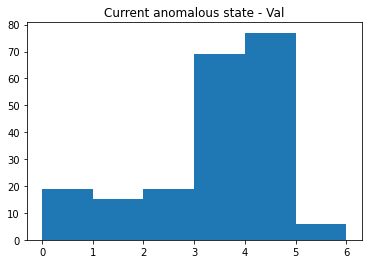

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.741463
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.118700


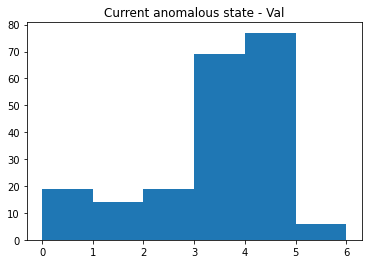

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.406863
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


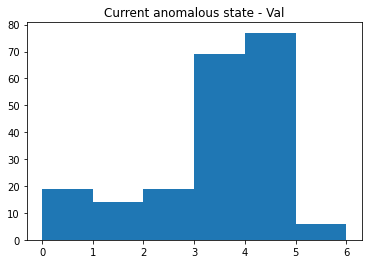

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.745098
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.128700


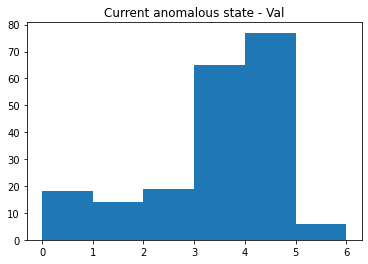

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.417085
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


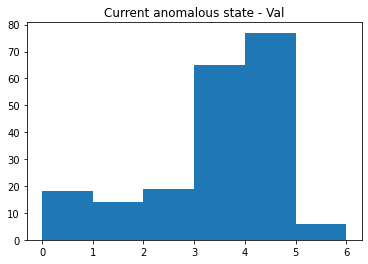

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.743719
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.536232
Threshold is 0.138700


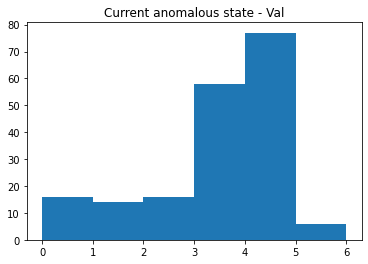

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.443850
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


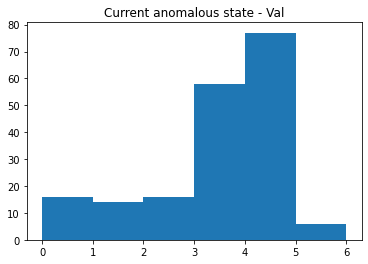

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.754011
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.510870
Threshold is 0.148700


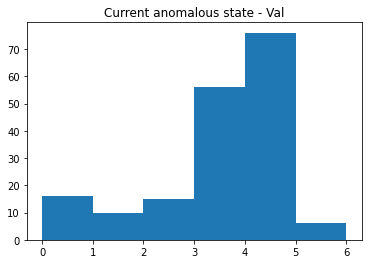

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.458101
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


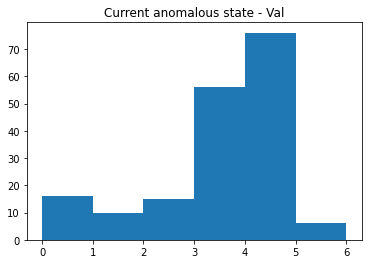

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.770950
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.500000


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of beta: 8
Threshold is 0.108700


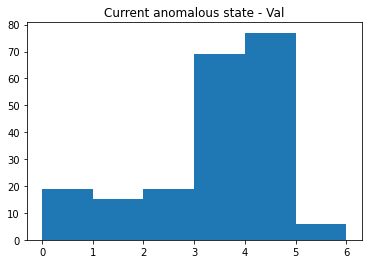

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.404878
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


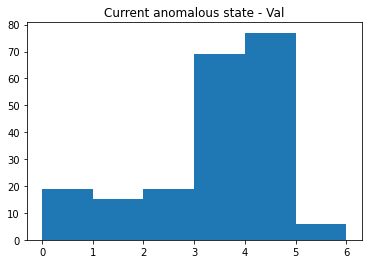

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.741463
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.118700


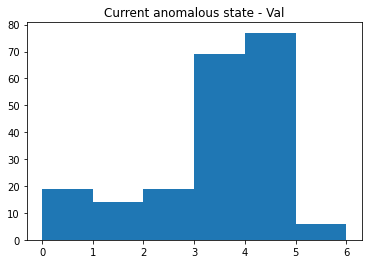

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.406863
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


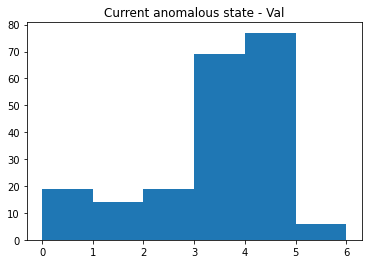

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.745098
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.128700


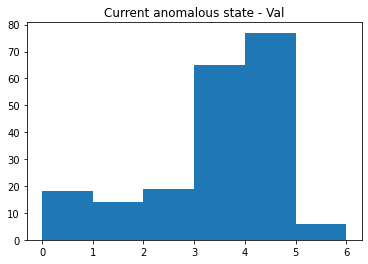

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.417085
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


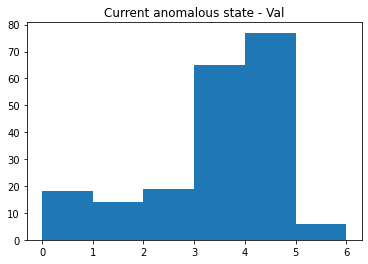

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.743719
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.536232
Threshold is 0.138700


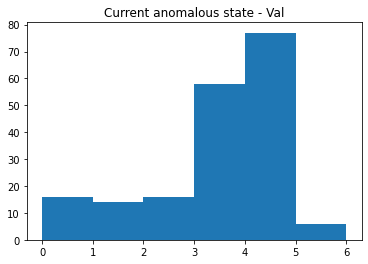

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.443850
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


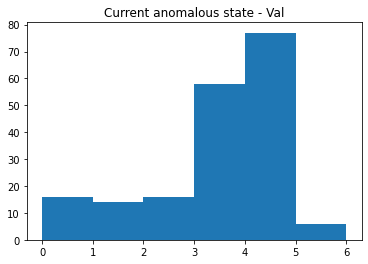

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.754011
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.510870
Threshold is 0.148700


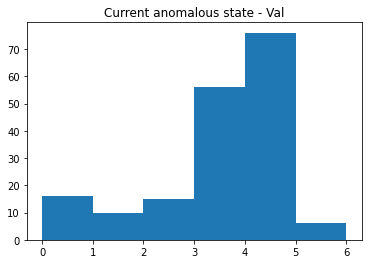

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.458101
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


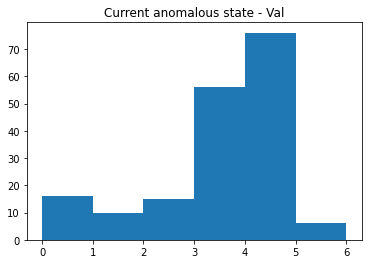

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.770950
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.500000


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of beta: 16
Threshold is 0.108700


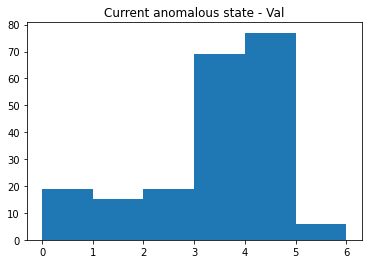

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.404878
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


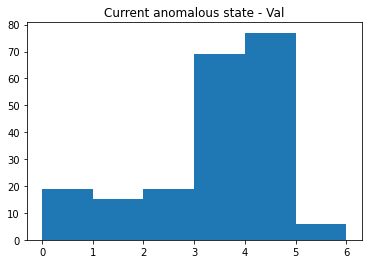

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.741463
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.118700


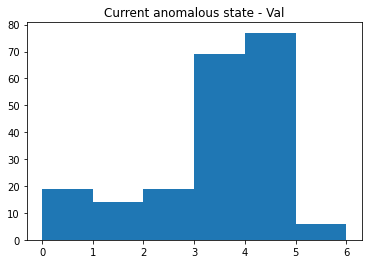

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.406863
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


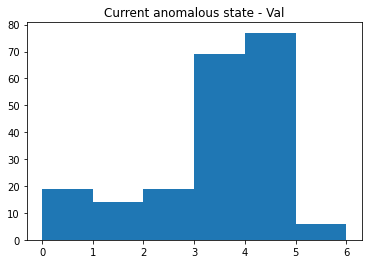

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.745098
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.128700


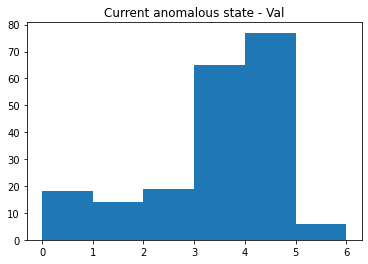

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.417085
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


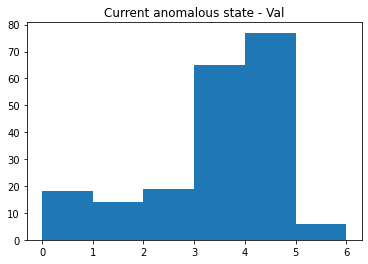

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.743719
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.536232
Threshold is 0.138700


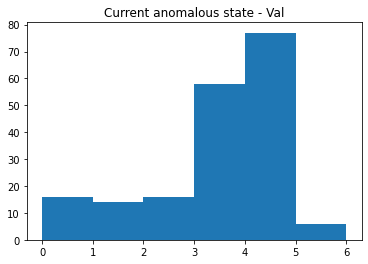

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.443850
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


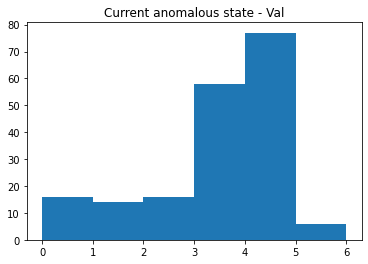

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.754011
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.510870
Threshold is 0.148700


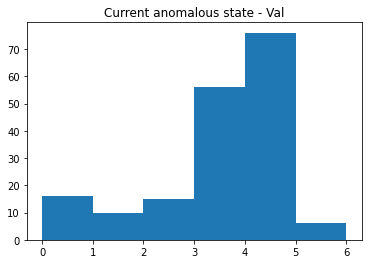

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.458101
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


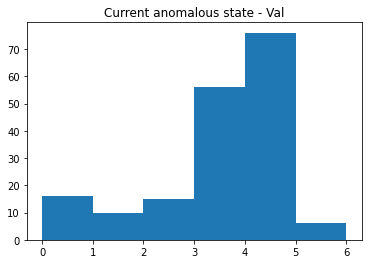

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.770950
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.500000


C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


Value of beta: 24
Threshold is 0.108700


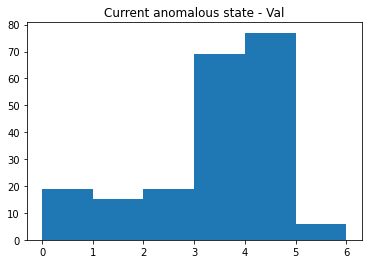

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.404878
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


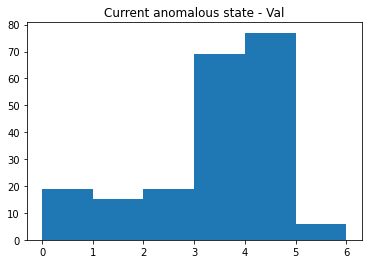

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.741463
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.118700


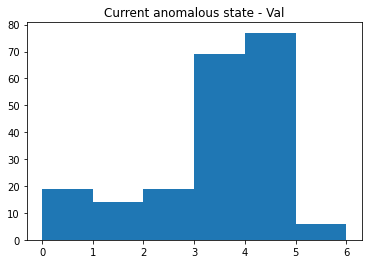

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.406863
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


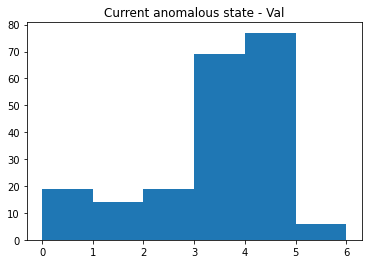

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.745098
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.128700


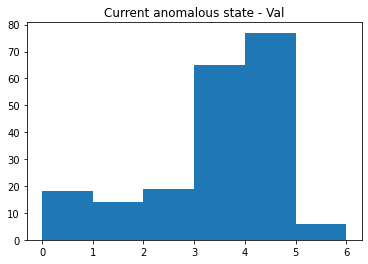

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.417085
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


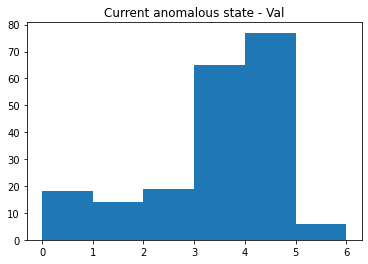

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.743719
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.536232
Threshold is 0.138700


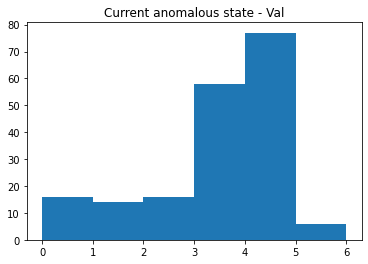

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.443850
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


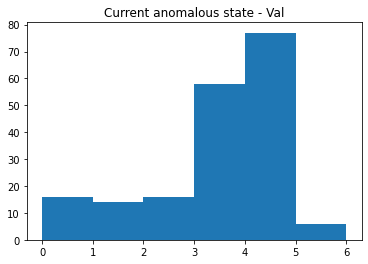

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.754011
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.510870
Threshold is 0.148700


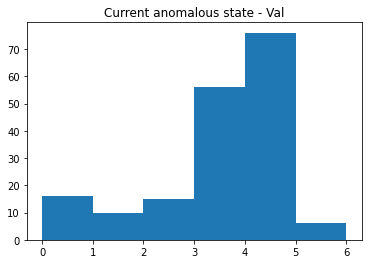

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.458101
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


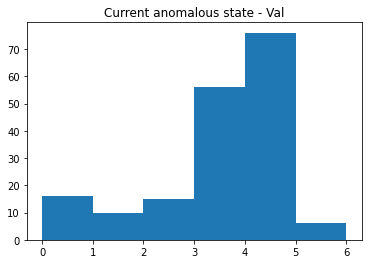

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.770950
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.500000


In [28]:
#Tune beta 
beta_list = [2, 4, 8, 16, 24]
for order in range(len(beta_list)):
    b = beta_list[order]
    clf5 = CBLOF(n_clusters=40, alpha=0.5, beta=b, random_state=42, contamination=outlier_ratio)
    clf5.fit(train_arr)
    print("Value of beta: %d" % b)
    
    threshold_test = thresholdArr5[order]
    val_score5 = clf5.decision_function(val_arr)
    
    for value in threshold_test:
        print("Threshold is %f" % value)
        processAnomalyWithoutState3(val_score5, np.array(val_arr), value, 'Val')
        processAnomalyWithState3(val_score5, np.array(val_arr), value, 'Val')

beta=4,8,16,24 gives the same performance. Use beta=8.

Try use_weights = true 

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


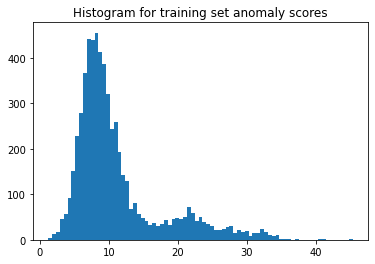

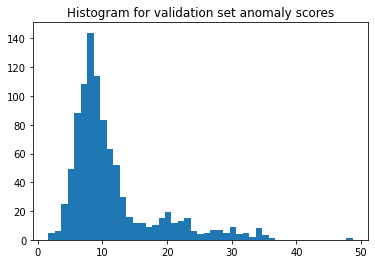

In [31]:
#Try use_weights = true 
clf6 = CBLOF(n_clusters=40, alpha=0.5, beta=8, use_weights=True, random_state=42, contamination=outlier_ratio)
clf6.fit(train_arr)
viewOutliers(clf6)

In [35]:
#calculate mean and stdev 
val_score6 = clf6.decision_function(val_arr)
val_normalIndex6 = getNormalIndex(val_state)
val_normalScores6 = getValuebyIndex(val_score6, val_normalIndex6)
valMean6 = statistics.mean(val_normalScores6)
valStdev6 = statistics.stdev(val_normalScores6)
val1Stdev6 = valMean6 + valStdev6
val2Stdev6 = valMean6 + valStdev6*2
    
print('Mean: %.4f. Stdev %.4f. 1 Stdev away: %.4f. 2 Stdev away %.4f.' % (valMean6, valStdev6, val1Stdev6, val2Stdev6))

Mean: 10.4397. Stdev 5.6199. 1 Stdev away: 16.0596. 2 Stdev away 21.6795.


Threshold is 14.059600


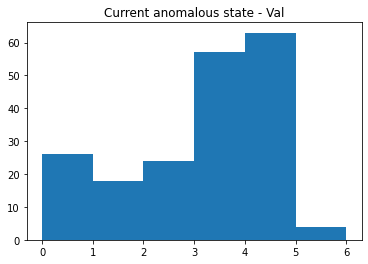

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.348958
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.807229


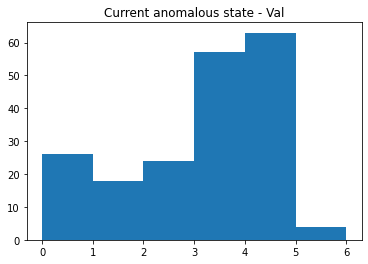

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.645833
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.449275
Threshold is 15.059600


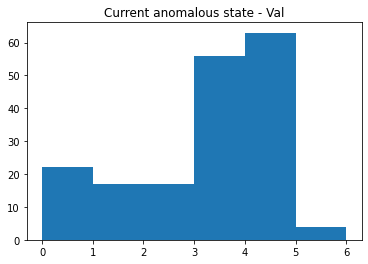

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.374302
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.807229


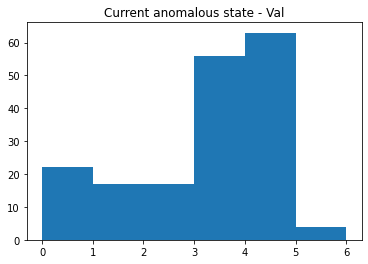

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.687151
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.445652
Threshold is 16.059600


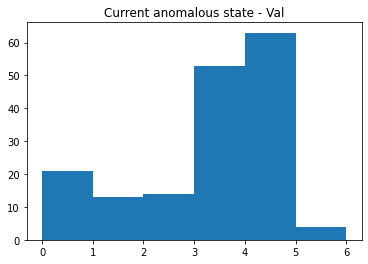

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.398810
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.807229


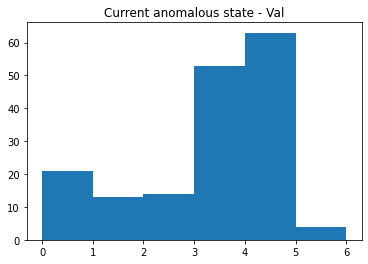

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.714286
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.434783
Threshold is 17.059600


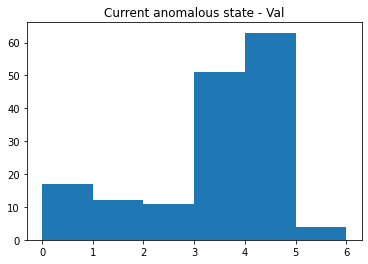

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.424051
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.807229


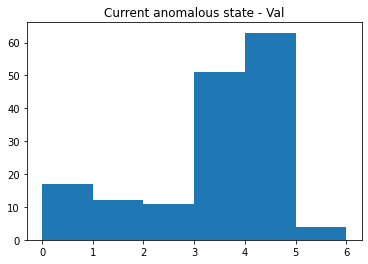

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.746835
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.427536
Threshold is 18.059600


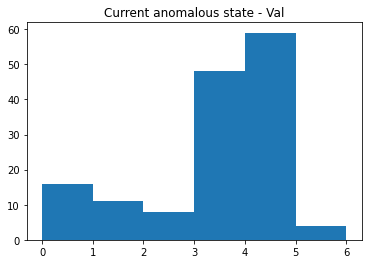

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.431507
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.759036


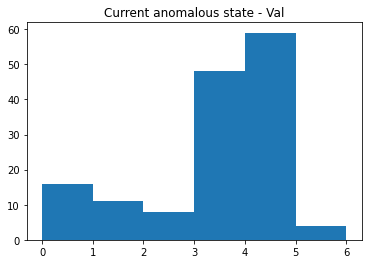

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.760274
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.402174


In [37]:
thresholdTest = [14.0596, 15.0596, 16.0596, 17.0596, 18.0596]
for value in thresholdTest:
    print("Threshold is %f" % value)
    processAnomalyWithoutState3(val_score6, np.array(val_arr), value, 'Val')
    processAnomalyWithState3(val_score6, np.array(val_arr), value, 'Val')

C:\Users\NG ZHI QING\anaconda3\envs\newvirtualenv\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


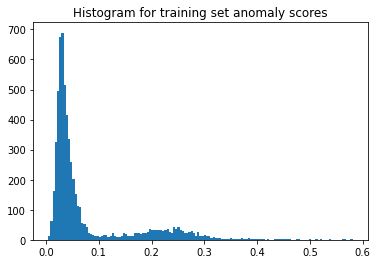

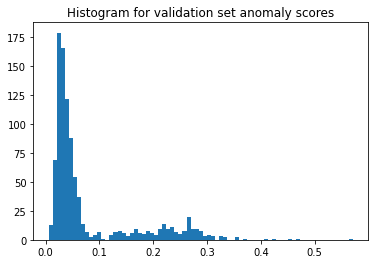

In [38]:
#Try use_weights = false 
clf7 = CBLOF(n_clusters=40, alpha=0.5, beta=8, use_weights=False, random_state=42, contamination=outlier_ratio)
clf7.fit(train_arr)
viewOutliers(clf7)

In [39]:
#calculate mean and stdev 
val_score7 = clf7.decision_function(val_arr)
val_normalIndex7 = getNormalIndex(val_state)
val_normalScores7 = getValuebyIndex(val_score7, val_normalIndex7)
valMean7 = statistics.mean(val_normalScores7)
valStdev7 = statistics.stdev(val_normalScores7)
val1Stdev7 = valMean7 + valStdev7
val2Stdev7 = valMean7 + valStdev7*2
    
print('Mean: %.4f. Stdev %.4f. 1 Stdev away: %.4f. 2 Stdev away %.4f.' % (valMean7, valStdev7, val1Stdev7, val2Stdev7))

Mean: 0.0613. Stdev 0.0674. 1 Stdev away: 0.1287. 2 Stdev away 0.1961.


Threshold is 0.108700


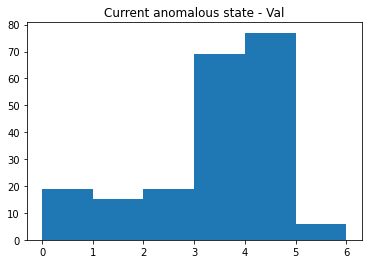

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.404878
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


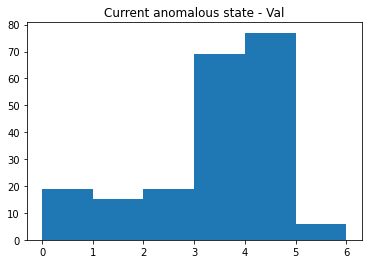

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.741463
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.118700


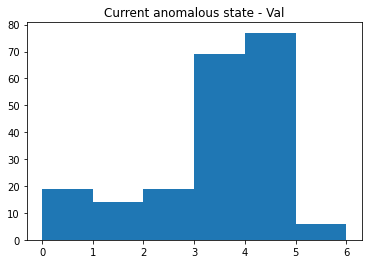

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.406863
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


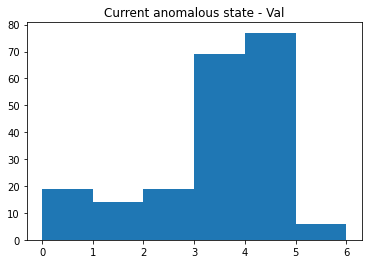

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.745098
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.550725
Threshold is 0.128700


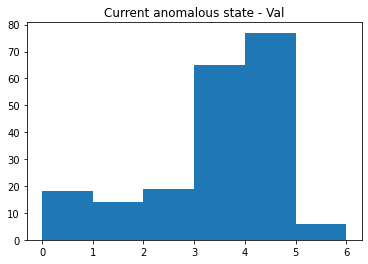

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.417085
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


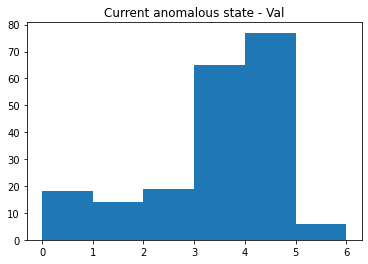

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.743719
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.536232
Threshold is 0.138700


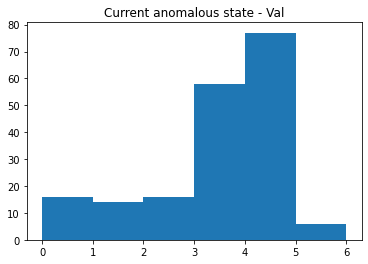

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.443850
Percentage of points in state 4 and 5 in validation set identified as anomalies: 1.000000


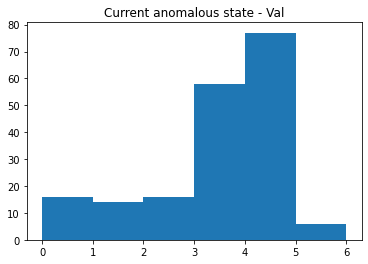

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.754011
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.510870
Threshold is 0.148700


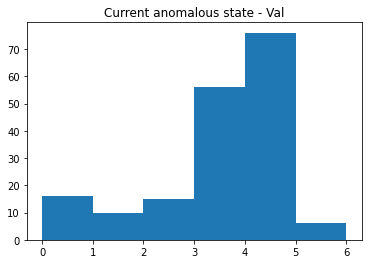

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.458101
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.987952


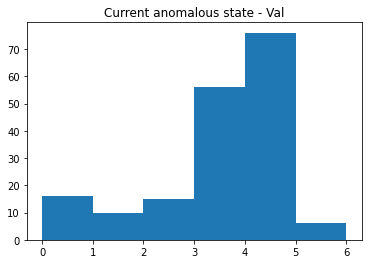

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.770950
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.500000


In [40]:
threshold_test = [0.1087, 0.1187, 0.1287, 0.1387, 0.1487]
for value in threshold_test:
    print("Threshold is %f" % value)
    processAnomalyWithoutState3(val_score7, np.array(val_arr), value, 'Val')
    processAnomalyWithState3(val_score7, np.array(val_arr), value, 'Val')

use_weights=False gave the best results with threshold = 0.1387